In [1]:
# Import libraries and modules
import sys
import tensorflow as tf
import numpy as np
import shutil
print(tf.__version__)
print(np.__version__)
np.set_printoptions(threshold = np.inf)

1.13.1
1.15.4


In [2]:
# tf.enable_eager_execution()
tf.executing_eagerly()

False

# Create data

## Create data generator

In [3]:
simple_data_genertator = False

percent_sequence_before_anomaly = 70.0
percent_sequence_after_anomaly = 0.0

def create_time_series_normal_parameters():
    normal_frequency_noise_scale = 1.0
    normal_frequence_noise_shift = 1.0

    normal_amplitude_noise_scale = 1.0
    normal_amplitude_noise_shift = 1.0

    normal_noise_noise_scale = 1.0

    if simple_data_genertator == True:
        normal_freq = 1.0
        normal_ampl = 1.0
    else:
        normal_freq = (np.random.random() * normal_frequency_noise_scale) + normal_frequence_noise_shift
        normal_ampl = np.random.random() * normal_amplitude_noise_scale + normal_amplitude_noise_shift
    
    return {"normal_freq": normal_freq, "normal_ampl": normal_ampl, "normal_noise_noise_scale": normal_noise_noise_scale}
  
def create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale):
    # Normal parameters
    if simple_data_genertator == True:
        sequence = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl for _ in range(number_of_sequences)], axis = 0)
    else:
        sequence = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl + [np.random.random() * normal_noise_noise_scale for i in range(sequence_length)] for _ in range(number_of_sequences)], axis = 0)

    return sequence

def create_time_series_with_anomaly(number_of_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, normal_freq, normal_ampl, normal_noise_noise_scale):
    sequence_length_before_anomaly = int(sequence_length * percent_sequence_before_anomaly / 100.0)
    sequence_length_after_anomaly = int(sequence_length * percent_sequence_after_anomaly / 100.0)
    sequence_length_anomaly = sequence_length - sequence_length_before_anomaly - sequence_length_after_anomaly

    # Anomalous parameters
    anomalous_amplitude_multipler_min = 8.0
    anomalous_amplitude_multipler_max = 20.0

    if simple_data_genertator == True:
        sequence_with_anomaly = np.stack(arrays = [np.sin(np.arange(0, sequence_length) * normal_freq) * normal_ampl for _ in range(number_of_sequences)], axis = 0)
    else:
        sequence_with_anomaly = create_time_series_normal(number_of_sequences, sequence_length, normal_freq, normal_ampl, normal_noise_noise_scale)
    sequence_with_anomaly[:, sequence_length_before_anomaly:sequence_length_before_anomaly + sequence_length_anomaly] *= ((anomalous_amplitude_multipler_max - anomalous_amplitude_multipler_min) * np.random.random_sample([number_of_sequences, sequence_length_anomaly]) + anomalous_amplitude_multipler_min) * (np.random.randint(2, size = [number_of_sequences, sequence_length_anomaly]) * -2 + 1)
    
    return sequence_with_anomaly

In [4]:
test_normal_parameters = create_time_series_normal_parameters()

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


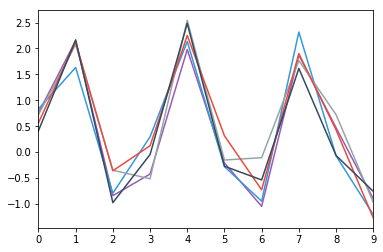

In [5]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 5):
    sns.tsplot(create_time_series_normal(1, 10, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

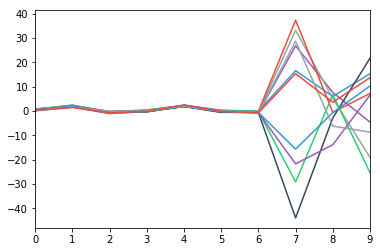

In [6]:
import seaborn as sns
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i in range(0, 10):
    sns.tsplot(create_time_series_with_anomaly(1, 10, percent_sequence_before_anomaly, percent_sequence_after_anomaly, test_normal_parameters["normal_freq"], test_normal_parameters["normal_ampl"], test_normal_parameters["normal_noise_noise_scale"]).reshape(-1), color=flatui[i%len(flatui)] )

## Create training and evaluation data

In [7]:
number_of_training_normal_sequences = 6400

number_of_validation_normal_1_sequences = 640
number_of_validation_normal_2_sequences = 640
number_of_validation_anomalous_sequences = 640

number_of_test_normal_sequences = 640
number_of_test_anomalous_sequences = 640

sequence_length = 10
number_of_tags = 5
tag_columns = ["tag_{0}".format(tag) for tag in range(0, number_of_tags)]

In [8]:
tag_data_list = [create_time_series_normal_parameters() for tag in range(0, number_of_tags)]
tag_data_list

[{'normal_ampl': 1.195367182017983,
  'normal_freq': 1.8356435803999118,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.3660525402623227,
  'normal_freq': 1.236727493579646,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.0481825472417177,
  'normal_freq': 1.3653518656672836,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.1237267066901628,
  'normal_freq': 1.591127332894927,
  'normal_noise_noise_scale': 1.0},
 {'normal_ampl': 1.6233183140115894,
  'normal_freq': 1.2957121851504065,
  'normal_noise_noise_scale': 1.0}]

In [9]:
# Create training set using normal sequences
training_normal_sequences_list = [create_time_series_normal(number_of_training_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
training_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = training_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_training_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
np.random.shuffle(training_normal_sequences_array)
print("training_normal_sequences_array.shape = \n{}".format(training_normal_sequences_array.shape))

training_normal_sequences_array.shape = 
(6400, 5)


In [10]:
# Create validation sets
# Create set vn1 of normal sequences which will be used for early stopping during training as well as using the error vectors to learn mu and sigma for mahalanobis distance
validation_normal_1_sequences_list = [create_time_series_normal(number_of_validation_normal_1_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_1_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_1_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_1_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_1_sequences_array.shape = \n{}".format(validation_normal_1_sequences_array.shape))

# Create set vn2 of normal sequences which will be used for tuning the anomaly thresholds
validation_normal_2_sequences_list = [create_time_series_normal(number_of_validation_normal_2_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_normal_2_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_normal_2_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_normal_2_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_normal_2_sequences_array.shape = \n{}".format(validation_normal_2_sequences_array.shape))

# Create set va of anomalous sequences which will be used for tuning the anomaly thresholds
validation_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_validation_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
validation_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = validation_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_validation_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("validation_anomalous_sequences_array.shape = \n{}".format(validation_anomalous_sequences_array.shape))

validation_normal_1_sequences_array.shape = 
(640, 5)
validation_normal_2_sequences_array.shape = 
(640, 5)
validation_anomalous_sequences_array.shape = 
(640, 5)


In [11]:
# Create test sets
# Create set tn of normal sequences which will be used for testing model
test_normal_sequences_list = [create_time_series_normal(number_of_test_normal_sequences, sequence_length, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_normal_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_normal_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_normal_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_normal_sequences_array.shape = \n{}".format(test_normal_sequences_array.shape))

# Create set ta of anomalous sequences which will be used for testing model
test_anomalous_sequences_list = [create_time_series_with_anomaly(number_of_test_anomalous_sequences, sequence_length, percent_sequence_before_anomaly, percent_sequence_after_anomaly, tag["normal_freq"], tag["normal_ampl"], tag["normal_noise_noise_scale"]) for tag in tag_data_list]
test_anomalous_sequences_array = np.stack(arrays = list(map(lambda i: np.stack(arrays = list(map(lambda j: np.array2string(a = test_anomalous_sequences_list[i][j], separator = ',').replace('[', '').replace(']', '').replace(' ', '').replace('\n', ''), np.arange(0, number_of_test_anomalous_sequences))), axis = 0), np.arange(0, number_of_tags))), axis = 1)
print("test_anomalous_sequences_array.shape = \n{}".format(test_anomalous_sequences_array.shape))

test_normal_sequences_array.shape = 
(640, 5)
test_anomalous_sequences_array.shape = 
(640, 5)


In [12]:
# Combine vn2 and va sets for tuning anomaly thresholds
labeled_validation_normal_2_sequences_array = np.concatenate(seq = [validation_normal_2_sequences_array, np.zeros(shape = [validation_normal_2_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_anomalous_sequences_array = np.concatenate(seq = [validation_anomalous_sequences_array, np.ones(shape = [validation_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_validation_mixed_sequences_array = np.concatenate(seq = [labeled_validation_normal_2_sequences_array, labeled_validation_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_validation_mixed_sequences_array)
print("labeled_validation_mixed_sequences_array.shape = \n{}".format(labeled_validation_mixed_sequences_array.shape))

# Combine tn and ta sets for testing model
labeled_test_normal_sequences_array = np.concatenate(seq = [test_normal_sequences_array, np.zeros(shape = [test_normal_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labled_test_anomalous_sequences_array = np.concatenate(seq = [test_anomalous_sequences_array, np.ones(shape = [test_anomalous_sequences_array.shape[0], 1], dtype = np.int64)], axis = 1)
labeled_test_mixed_sequences_array = np.concatenate(seq = [labeled_test_normal_sequences_array, labled_test_anomalous_sequences_array], axis = 0)
np.random.shuffle(labeled_test_mixed_sequences_array)
print("labeled_test_mixed_sequences_array.shape = \n{}".format(labeled_test_mixed_sequences_array.shape))

labeled_validation_mixed_sequences_array.shape = 
(1280, 6)
labeled_test_mixed_sequences_array.shape = 
(1280, 6)


In [13]:
np.savetxt(fname = "data/training_normal_sequences.csv", X = training_normal_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/validation_normal_1_sequences.csv", X = validation_normal_1_sequences_array, fmt = '%s', delimiter = ";")
np.savetxt(fname = "data/labeled_validation_mixed_sequences.csv", X = labeled_validation_mixed_sequences_array, fmt = '%s', delimiter = ";")

np.savetxt(fname = "data/labeled_test_mixed_sequences.csv", X = labeled_test_mixed_sequences_array, fmt = '%s', delimiter = ";")

In [14]:
!head -3 data/training_normal_sequences.csv

0.07145266,1.9097913,0.2208629,-0.28855601,1.46468172,1.1474758,-0.79399797,1.23329431,1.77662805,0.12465823;0.87794426,2.05263438,0.93672853,-0.34045753,-0.66624789,0.28001689,2.12362829,0.99671433,-0.15007566,-0.59117085;0.93841583,1.19805079,0.91833718,-0.82054641,-0.5496651,0.72726593,1.67492556,0.36604246,-0.17812902,0.6489562;0.10255582,1.39799027,0.405437,-0.7748188,0.86147266,1.24959065,0.07452085,-0.65237741,1.15281996,1.25206098;0.38921343,1.652179,1.44887929,-0.18533891,-0.61363922,0.70510979,2.04337896,1.5127308,-0.7711545,-0.95658998
0.35935981,1.37232564,0.09414848,-0.70817046,1.91756272,0.55119466,-0.78069231,0.38595424,2.00350011,-0.80311872;0.91227843,1.71345285,1.63944784,0.18264546,-0.3475563,0.50970397,1.72885434,1.00009181,-0.40138214,-0.57207834;0.00973479,1.85036391,0.68057962,-0.13427597,-0.28785897,0.62490112,1.68586514,0.4984213,-0.8367616,-0.16756714;0.93595208,1.40640709,0.3587726,-0.5871258,0.4478235,1.23189687,-0.11399398,-0.48418837,1.01552325,2.07492019;

In [15]:
!head -3 data/validation_normal_1_sequences.csv

0.98624024,1.66016233,-0.3347478,-0.18283713,1.43292092,0.61285117,-1.12202809,1.23944689,1.76283783,-0.22994744;0.36919269,1.71141525,1.32346,-0.31734012,-0.64247042,-0.01378687,1.48441536,1.60586465,-0.27729633,-0.95884944;0.37391749,1.91363665,0.97159026,-0.58902794,-0.32857617,0.92057499,1.64780506,0.18004972,-0.32943849,0.43120538;0.2472807,1.73061859,0.16659371,-0.57707014,0.8762916,1.9547276,0.41270493,-0.47490666,0.32448047,1.43193249;0.99230569,1.94653558,0.95649104,-0.8105762,-1.02652618,1.00386683,1.70379708,1.08402501,-0.49401976,-0.93814283
0.39116143,1.26061429,0.05233716,-0.30166845,1.30094404,0.57051706,-0.37542127,0.88707823,1.06078568,-0.25334306;0.60470908,1.96160945,1.38365624,-0.14633174,-0.5932539,-0.08233292,1.84757702,1.9176284,0.31722435,-0.82000442;0.45250439,2.01352197,0.47705556,-0.85217704,0.10995947,1.09314925,1.97254497,0.38887045,-0.79635608,0.69804274;0.3499861,2.00851739,0.16340734,-0.76227879,0.26714336,2.09963965,0.77808706,-0.84626408,0.33595568,1.7

In [16]:
!head -3 data/labeled_validation_mixed_sequences.csv

0.88944464,1.85688634,0.30428222,-0.65501457,1.35459916,0.91934669,-0.64640319,0.46087741,1.8084806,0.00672831;0.65196509,2.01287793,1.48516687,-0.61928654,-0.75511986,0.00995365,2.22074827,1.53941642,-0.31351779,-1.02635964;0.14897559,1.93630608,0.60456247,-0.38597851,-0.65995837,1.50467906,1.46262618,0.49536735,-0.39671324,0.08136951;0.96887917,1.28430647,0.92830536,-0.35816449,0.94311668,1.39217764,0.70692049,-1.08340814,0.67431744,1.22853006;0.75045298,2.06884131,1.01204576,-0.70932428,-0.94309227,1.30889631,2.36874682,0.94389333,-0.83295416,-0.60193385;0
0.79135569,1.45092595,-0.43537681,-0.2739977,1.2175742,1.04339237,-0.20037614,-16.404432,17.64799595,-0.14875001;0.65153422,2.27992745,0.91343774,-0.23736357,-0.75764173,0.15399886,2.214798,19.82213434,-2.71460404,-8.14150721;0.45942889,1.30480557,0.53087091,-0.55025755,-0.16456096,1.29075593,1.28244895,-7.01883644,15.39527031,5.6013878;0.77278597,1.67611863,0.55463489,-0.40732653,0.37947031,2.07258042,0.72408052,7.00853234,-4.106

In [17]:
!head -3 data/labeled_test_mixed_sequences.csv

0.94718299,1.81178634,-0.10987578,-0.7591035,1.12325615,1.02957954,-0.47177616,-8.66708823,-15.16813576,-5.72166587;0.60290752,1.64504845,0.92109889,-0.55699153,-0.96610747,0.10094842,1.69013299,-24.19053325,-7.20207535,16.21935392;0.75155777,1.21816619,0.42253052,-0.56018596,0.02620436,0.85622519,1.57171311,12.00618703,-12.88831336,-1.300047;0.52896004,1.59325404,0.07329098,-1.10108936,0.29128286,1.90519597,0.48499144,2.38217522,19.48286342,17.53521187;0.64544871,2.49247538,1.66423785,-0.69850758,-0.54157138,0.88784962,2.40317372,-7.83528668,17.26482862,-5.8722338;1
0.80917287,2.08298358,0.20704932,-0.58896247,1.19876176,0.41948789,-0.61173655,0.95833565,1.23869281,-0.23701212;0.20549701,1.78227237,1.25557807,-0.68183844,-0.41998369,-0.05681893,1.29985933,1.54218658,-0.27178976,-1.20111945;0.58879589,1.82445155,1.37545622,-0.14234353,-0.75940906,1.30685993,1.36547101,0.28090471,-0.89328515,0.36946595;0.40254233,1.31606103,0.21137696,-0.13366635,0.63092719,1.8877315,0.04555099,-0.24296

# Local Development

In [18]:
# Set logging to be level of INFO
tf.logging.set_verbosity(tf.logging.INFO)

In [19]:
# Determine CSV and label columns
UNLABELED_CSV_COLUMNS = tag_columns

LABEL_COLUMN = "anomalous_sequence_flag"
LABELED_CSV_COLUMNS = UNLABELED_CSV_COLUMNS + [LABEL_COLUMN]

# Set default values for each CSV column
UNLABELED_DEFAULTS = [[""] for _ in UNLABELED_CSV_COLUMNS]

LABELED_DEFAULTS = UNLABELED_DEFAULTS + [[0.0]]

In [20]:
# Create an input function reading a file using the Dataset API
# Then provide the results to the Estimator API
def read_dataset(filename, mode, batch_size, params):
    def _input_fn():
        def decode_csv(value_column, sequence_length):
            def convert_sequences_from_strings_to_floats(features, column_list):
                def split_and_convert_string(string_tensor):
                    # Split string tensor into a sparse tensor based on delimiter
                    split_string = tf.string_split(source = tf.expand_dims(input = string_tensor, axis = 0), delimiter = ",")

                    # Converts the values of the sparse tensor to floats
                    converted_tensor = tf.string_to_number(split_string.values, out_type = tf.float64)

                    # Create a new sparse tensor with the new converted values, because the original sparse tensor values are immutable
                    new_sparse_tensor = tf.SparseTensor(indices = split_string.indices, values = converted_tensor, dense_shape = split_string.dense_shape)

                    # Create a dense tensor of the float values that were converted from text csv
                    dense_floats = tf.sparse_tensor_to_dense(sp_input = new_sparse_tensor, default_value = 0.0)

                    dense_floats_vector = tf.squeeze(input = dense_floats, axis = 0)

                    return dense_floats_vector
                    
                for column in column_list:
                    features[column] = split_and_convert_string(features[column])
                    features[column].set_shape([sequence_length])

                return features
                
            if mode == tf.estimator.ModeKeys.TRAIN or (mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] != "tune_anomaly_thresholds"):
                columns = tf.decode_csv(records = value_column, record_defaults = UNLABELED_DEFAULTS, field_delim = ";")
                features = dict(zip(UNLABELED_CSV_COLUMNS, columns))
                features = convert_sequences_from_strings_to_floats(features, UNLABELED_CSV_COLUMNS)
                return features
            else:
                columns = tf.decode_csv(records = value_column, record_defaults = LABELED_DEFAULTS, field_delim = ";")
                features = dict(zip(LABELED_CSV_COLUMNS, columns))
                labels = tf.cast(x = features.pop(LABEL_COLUMN), dtype = tf.float64)
                features = convert_sequences_from_strings_to_floats(features, LABELED_CSV_COLUMNS[0:-1])
                return features, labels
        
        # Create list of files that match pattern
        file_list = tf.gfile.Glob(filename = filename)

        # Create dataset from file list
        dataset = tf.data.TextLineDataset(filenames = file_list)    # Read text file

        # Decode the CSV file into a features dictionary of tensors
        dataset = dataset.map(map_func = lambda x: decode_csv(x, params["sequence_length"]))
        
        # Determine amount of times to repeat file based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = None # indefinitely
        else:
            num_epochs = 1 # end-of-input after this

        # Repeat files num_epoch times
        dataset = dataset.repeat(count = num_epochs)

        # Group the data into batches
        dataset = dataset.batch(batch_size = batch_size)
        
        # Determine if we should shuffle based on if we are training or evaluating
        if mode == tf.estimator.ModeKeys.TRAIN:
            dataset = dataset.shuffle(buffer_size = 10 * batch_size)

        # Create a iterator and then pull the next batch of features from the example queue
        batched_dataset = dataset.make_one_shot_iterator().get_next()

        return batched_dataset
    return _input_fn

In [21]:
def try_out_input_function():
    with tf.Session() as sess:
        fn = read_dataset(
          filename = "data/labeled_validation_mixed_sequences.csv",
          mode = tf.estimator.ModeKeys.EVAL,
          batch_size = 8,
          params = {"sequence_length": sequence_length,
                    "evaluation_mode": "tune_anomaly_thresholds"})

        features = sess.run(fn())
        print("try_out_input_function: features = \n{}".format(features))

#         print("try_out_input_function: features[tag_0].shape = {}".format(features["tag_0"].shape))

In [22]:
# try_out_input_function()

In [23]:
# This function updates the count of records used
def update_count(count_a, count_b):
    return count_a + count_b

# This function updates the variables when the number_of_rows equals 1
def singleton_batch_variable_updating(inner_size, reshaped, count_variable, mean_variable, covariance_matrix_variable):
    # This function updates the mean vector incrementally
    def update_mean_incremental(count_a, mean_a, value_b):
        return (mean_a * tf.cast(x = count_a, dtype = tf.float64) + tf.squeeze(input = value_b, axis = 0)) / tf.cast(x = count_a + 1, dtype = tf.float64)

    # This function updates the covariance matrix incrementally
    def update_covariance_incremental(count_a, mean_a, cov_a, value_b, mean_ab, sample_covariance):
        if sample_covariance == True:
            cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) / tf.cast(x = count_a, dtype = tf.float64)
        else:
            cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + tf.matmul(a = value_b - mean_a, b = value_b - mean_ab, transpose_a = True)) / tf.cast(x = count_a + 1, dtype = tf.float64)
        return cov_ab

    # Calculate new combined mean to use for incremental covariance matrix calculation
    mean_ab = update_mean_incremental(count_a = count_variable, 
                                      mean_a = mean_variable, 
                                      value_b = reshaped) # time_shape = (number_of_features,), features_shape = (sequence_length,)

    # Update running variables from single example
    count_tensor = update_count(count_a = count_variable, count_b = 1) # time_shape = (), features_shape = ()

    mean_tensor = mean_ab # time_shape = (number_of_features,), features_shape = (sequence_length,)

    if inner_size == 1:
        covariance_matrix_tensor = tf.zeros_like(tensor = covariance_matrix_variable, dtype = tf.float64)
    else:
        covariance_matrix_tensor = update_covariance_incremental(count_a = count_variable, 
                                                                 mean_a = mean_variable, 
                                                                 cov_a = covariance_matrix_variable, 
                                                                 value_b = reshaped, 
                                                                 mean_ab = mean_ab, 
                                                                 sample_covariance = True) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

    # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
    with tf.control_dependencies(control_inputs = [tf.assign(ref = covariance_matrix_variable, value = covariance_matrix_tensor)]):
        with tf.control_dependencies(control_inputs = [tf.assign(ref = mean_variable, value = mean_tensor)]):
            with tf.control_dependencies(control_inputs = [tf.assign(ref = count_variable, value = count_tensor)]):
                return tf.identity(input = covariance_matrix_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable)

# This function updates the variables when the number_of_rows does NOT equal 1
def non_singleton_batch_variable_updating(current_batch_size, inner_size, reshaped, count_variable, mean_variable, covariance_matrix_variable):
    # This function updates the mean vector using a batch of data
    def update_mean_batch(count_a, mean_a, count_b, mean_b):
        return (mean_a * tf.cast(x = count_a, dtype = tf.float64) + mean_b * tf.cast(x = count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)

    # This function updates the covariance matrix using a batch of data
    def update_covariance_batch(count_a, mean_a, cov_a, count_b, mean_b, cov_b, sample_covariance):
        mean_diff = tf.expand_dims(input = mean_a - mean_b, axis = 0)

        if sample_covariance == True:
            cov_ab = (cov_a * tf.cast(x = count_a - 1, dtype = tf.float64) + cov_b * tf.cast(x = count_b - 1, dtype = tf.float64) + tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b - 1, dtype = tf.float64)
        else:
            cov_ab = (cov_a * tf.cast(x = count_a, dtype = tf.float64) + cov_b * tf.cast(x = count_b, dtype = tf.float64) + tf.matmul(a = mean_diff, b = mean_diff, transpose_a = True) * tf.cast(x = count_a * count_b, dtype = tf.float64) / tf.cast(x = count_a + count_b, dtype = tf.float64)) / tf.cast(x = count_a + count_b, dtype = tf.float64)
        return cov_ab                    

    # Find statistics of batch
    number_of_rows = current_batch_size * inner_size

    reshaped_mean = tf.reduce_mean(input_tensor = reshaped, axis = 0) # time_shape = (number_of_features,), features_shape = (sequence_length,)

    reshaped_centered = reshaped - reshaped_mean # time_shape = (current_batch_size * sequence_length, number_of_features), features_shape = (current_batch_size * number_of_features, sequence_length)

    if inner_size > 1:
        reshaped_covariance_matrix = tf.matmul(a = reshaped_centered, # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)
                                               b = reshaped_centered, 
                                               transpose_a = True) / tf.cast(x = number_of_rows - 1, dtype = tf.float64)

    # Update running variables from batch statistics
    count_tensor = update_count(count_a = count_variable, count_b = number_of_rows) # time_shape = (), features_shape = ()

    mean_tensor = update_mean_batch(count_a = count_variable, 
                                    mean_a = mean_variable, 
                                    count_b = number_of_rows, 
                                    mean_b = reshaped_mean) # time_shape = (number_of_features,), features_shape = (sequence_length,)

    if inner_size == 1:
        covariance_matrix_tensor = tf.zeros_like(tensor = covariance_matrix_variable, dtype = tf.float64)
    else:
        covariance_matrix_tensor = update_covariance_batch(count_a = count_variable, 
                                                           mean_a = mean_variable, 
                                                           cov_a = covariance_matrix_variable, 
                                                           count_b = number_of_rows, 
                                                           mean_b = reshaped_mean, 
                                                           cov_b = reshaped_covariance_matrix, 
                                                           sample_covariance = True) # time_shape = (number_of_features, number_of_features), features_shape = (sequence_length, sequence_length)

    # Assign values to variables, use control dependencies around return to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
    with tf.control_dependencies(control_inputs = [tf.assign(ref = covariance_matrix_variable, value = covariance_matrix_tensor)]):
        with tf.control_dependencies(control_inputs = [tf.assign(ref = mean_variable, value = mean_tensor)]):
            with tf.control_dependencies(control_inputs = [tf.assign(ref = count_variable, value = count_tensor)]):
                return tf.identity(input = covariance_matrix_variable), tf.identity(input = mean_variable), tf.identity(input = count_variable)

In [24]:
# Create our model function to be used in our custom estimator
def pca_anomaly_detection(features, labels, mode, params):
    print("\npca_anomaly_detection: features = \n{}".format(features))
    print("pca_anomaly_detection: labels = \n{}".format(labels))
    print("pca_anomaly_detection: mode = \n{}".format(mode))
    print("pca_anomaly_detection: params = \n{}".format(params))

    # 0. Get input sequence tensor into correct shape
    # Get dynamic batch size in case there was a partially filled batch
    current_batch_size = tf.shape(input = features[UNLABELED_CSV_COLUMNS[0]], out_type = tf.int64)[0]

    # Get the number of features 
    number_of_features = len(UNLABELED_CSV_COLUMNS)

    # Stack all of the features into a 3-D tensor
    X = tf.stack(values = [features[key] for key in UNLABELED_CSV_COLUMNS], axis = 2) # shape = (current_batch_size, sequence_length, number_of_features)

    # Reshape into a 2-D tensors
    # Time based
    X_time = tf.reshape(tensor = X, shape = [current_batch_size * params["sequence_length"], number_of_features]) # shape = (current_batch_size * sequence_length, number_of_features)
    
    # Features based
    X_transposed = tf.transpose(a = X, perm = [0, 2, 1]) # shape = (current_batch_size, number_of_features, sequence_length)
    X_features = tf.reshape(tensor = X_transposed, shape = [current_batch_size * number_of_features, params["sequence_length"]]) # shape = (current_batch_size * number_of_features, sequence_length)

    ################################################################################
  
    # Variables for calculating error distribution statistics
    with tf.variable_scope(name_or_scope = "pca_variables", reuse = tf.AUTO_REUSE):
        # Time based
        pca_time_count_variable = tf.get_variable(name = "pca_time_count_variable", # shape = ()
                                                  dtype = tf.int64,
                                                  initializer = tf.zeros(shape = [], 
                                                                         dtype = tf.int64),
                                                  trainable = False)
        
        pca_time_mean_variable = tf.get_variable(name = "pca_time_mean_variable", # shape = (number_of_features,)
                                                 dtype = tf.float64,
                                                 initializer = tf.zeros(shape = [number_of_features], 
                                                                        dtype = tf.float64),
                                                 trainable = False)
        
        pca_time_covariance_matrix_variable = tf.get_variable(name = "pca_time_covariance_matrix_variable", # shape = (number_of_features, number_of_features)
                                                              dtype = tf.float64,
                                                              initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                     dtype = tf.float64),
                                                              trainable = False)

        pca_time_eigenvalues_variable = tf.get_variable(name = "pca_time_eigenvalues_variable", # shape = (number_of_features,)
                                                        dtype = tf.float64,
                                                        initializer = tf.zeros(shape = [number_of_features], 
                                                                               dtype = tf.float64),
                                                        trainable = False)
        
        pca_time_eigenvectors_variable = tf.get_variable(name = "pca_time_eigenvectors_variable", # shape = (number_of_features, number_of_features)
                                                         dtype = tf.float64,
                                                         initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                dtype = tf.float64),
                                                         trainable = False)
        
        
        # Features based
        pca_features_count_variable = tf.get_variable(name = "pca_features_count_variable", # shape = ()
                                                      dtype = tf.int64,
                                                      initializer = tf.zeros(shape = [], 
                                                                             dtype = tf.int64),
                                                      trainable = False)
        
        pca_features_mean_variable = tf.get_variable(name = "pca_features_mean_variable", # shape = (sequence_length,)
                                                     dtype = tf.float64,
                                                     initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                            dtype = tf.float64),
                                                     trainable = False)
        
        pca_features_covariance_matrix_variable = tf.get_variable(name = "pca_features_covariance_matrix_variable", # shape = (sequence_length, sequence_length)
                                                                  dtype = tf.float64,
                                                                  initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                         dtype = tf.float64),
                                                                  trainable = False)

        pca_features_eigenvalues_variable = tf.get_variable(name = "pca_features_eigenvalues_variable", # shape = (sequence_length,)
                                                            dtype = tf.float64,
                                                            initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                                   dtype = tf.float64),
                                                            trainable = False)
        
        pca_features_eigenvectors_variable = tf.get_variable(name = "pca_features_eigenvectors_variable", # shape = (sequence_length, sequence_length)
                                                             dtype = tf.float64,
                                                             initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                    dtype = tf.float64),
                                                             trainable = False)
  
    # Variables for calculating error distribution statistics
    with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
        # Time based
        absolute_error_count_batch_time_variable = tf.get_variable(name = "absolute_error_count_batch_time_variable", # shape = ()
                                                                   dtype = tf.int64,
                                                                   initializer = tf.zeros(shape = [], 
                                                                                          dtype = tf.int64),
                                                                   trainable = False)
        
        absolute_error_mean_batch_time_variable = tf.get_variable(name = "absolute_error_mean_batch_time_variable", # shape = (number_of_features,)
                                                                  dtype = tf.float64,
                                                                  initializer = tf.zeros(shape = [number_of_features], 
                                                                                         dtype = tf.float64),
                                                                  trainable = False)
        
        absolute_error_covariance_matrix_batch_time_variable = tf.get_variable(name = "absolute_error_covariance_matrix_batch_time_variable", # shape = (number_of_features, number_of_features)
                                                                               dtype = tf.float64,
                                                                               initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                                      dtype = tf.float64),
                                                                               trainable = False)

        absolute_error_inverse_covariance_matrix_batch_time_variable = tf.get_variable(name = "absolute_error_inverse_covariance_matrix_batch_time_variable", # shape = (number_of_features, number_of_features)
                                                                                       dtype = tf.float64,
                                                                                       initializer = tf.zeros(shape = [number_of_features, number_of_features], 
                                                                                                              dtype = tf.float64),
                                                                                       trainable = False)

        # Features based
        absolute_error_count_batch_features_variable = tf.get_variable(name = "absolute_error_count_batch_features_variable", # shape = ()
                                                                       dtype = tf.int64,
                                                                       initializer = tf.zeros(shape = [], 
                                                                                              dtype = tf.int64),
                                                                       trainable = False)
        
        absolute_error_mean_batch_features_variable = tf.get_variable(name = "absolute_error_mean_batch_features_variable", # shape = (sequence_length,)
                                                                      dtype = tf.float64,
                                                                      initializer = tf.zeros(shape = [params["sequence_length"]], 
                                                                                             dtype = tf.float64),
                                                                      trainable = False)
        
        absolute_error_covariance_matrix_batch_features_variable = tf.get_variable(name = "absolute_error_covariance_matrix_batch_features_variable", # shape = (sequence_length, sequence_length)
                                                                                   dtype = tf.float64,
                                                                                   initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                                          dtype = tf.float64),
                                                                                   trainable = False)

        absolute_error_inverse_covariance_matrix_batch_features_variable = tf.get_variable(name = "absolute_error_inverse_covariance_matrix_batch_features_variable", # shape = (sequence_length, sequence_length)
                                                                                           dtype = tf.float64,
                                                                                           initializer = tf.zeros(shape = [params["sequence_length"], params["sequence_length"]], 
                                                                                                                  dtype = tf.float64),
                                                                                           trainable = False)
    
    # Variables for automatically tuning anomaly thresholds
    with tf.variable_scope(name_or_scope = "mahalanobis_distance_threshold_variables", reuse = tf.AUTO_REUSE):
        # Time based
        true_positives_at_thresholds_time_variable = tf.get_variable(name = "true_positives_at_thresholds_time_variable", # shape = (number_of_batch_time_anomaly_thresholds,)
                                                                     dtype = tf.int64,
                                                                     initializer = tf.zeros(shape = [params["number_of_batch_time_anomaly_thresholds"]], 
                                                                                            dtype = tf.int64),
                                                                     trainable = False)

        false_negatives_at_thresholds_time_variable = tf.get_variable(name = "false_negatives_at_thresholds_time_variable", # shape = (number_of_batch_time_anomaly_thresholds,)
                                                                      dtype = tf.int64,
                                                                      initializer = tf.zeros(shape = [params["number_of_batch_time_anomaly_thresholds"]], 
                                                                                             dtype = tf.int64),
                                                                      trainable = False)

        false_positives_at_thresholds_time_variable = tf.get_variable(name = "false_positives_at_thresholds_time_variable", # shape = (number_of_batch_time_anomaly_thresholds,)
                                                                      dtype = tf.int64,
                                                                      initializer = tf.zeros(shape = [params["number_of_batch_time_anomaly_thresholds"]], 
                                                                                             dtype = tf.int64),
                                                                      trainable = False)

        true_negatives_at_thresholds_time_variable = tf.get_variable(name = "true_negatives_at_thresholds_time_variable", # shape = (number_of_batch_time_anomaly_thresholds,)
                                                                     dtype = tf.int64,
                                                                     initializer = tf.zeros(shape = [params["number_of_batch_time_anomaly_thresholds"]], 
                                                                                            dtype = tf.int64),
                                                                     trainable = False)
        
        time_anomaly_threshold_variable = tf.get_variable(name = "time_anomaly_threshold_variable", # shape = ()
                                                          dtype = tf.float64,
                                                          initializer = tf.zeros(shape = [], 
                                                                                 dtype = tf.float64),
                                                          trainable = False)

        # Features based
        true_positives_at_thresholds_features_variable = tf.get_variable(name = "true_positives_at_thresholds_features_variable", # shape = (number_of_batch_features_anomaly_thresholds,)
                                                                         dtype = tf.int64,
                                                                         initializer = tf.zeros(shape = [params["number_of_batch_features_anomaly_thresholds"]], 
                                                                                                dtype = tf.int64),
                                                                         trainable = False)

        false_negatives_at_thresholds_features_variable = tf.get_variable(name = "false_negatives_at_thresholds_features_variable", # shape = (number_of_batch_features_anomaly_thresholds,)
                                                                          dtype = tf.int64,
                                                                          initializer = tf.zeros(shape = [params["number_of_batch_features_anomaly_thresholds"]], 
                                                                                                 dtype = tf.int64),
                                                                          trainable = False)

        false_positives_at_thresholds_features_variable = tf.get_variable(name = "false_positives_at_thresholds_features_variable", # shape = (number_of_batch_features_anomaly_thresholds,)
                                                                          dtype = tf.int64,
                                                                          initializer = tf.zeros(shape = [params["number_of_batch_features_anomaly_thresholds"]], 
                                                                                                 dtype = tf.int64),
                                                                          trainable = False)

        true_negatives_at_thresholds_features_variable = tf.get_variable(name = "true_negatives_at_thresholds_features_variable", # shape = (number_of_batch_features_anomaly_thresholds,)
                                                                         dtype = tf.int64,
                                                                         initializer = tf.zeros(shape = [params["number_of_batch_features_anomaly_thresholds"]], 
                                                                                                dtype = tf.int64),
                                                                         trainable = False)
        
        features_anomaly_threshold_variable = tf.get_variable(name = "features_anomaly_threshold_variable", # shape = ()
                                                              dtype = tf.float64,
                                                              initializer = tf.zeros(shape = [], 
                                                                                     dtype = tf.float64),
                                                              trainable = False)
        
    # Variables for automatically tuning anomaly thresholds
    with tf.variable_scope(name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
        # Time based
        true_positives_at_threshold_eval_time_variable = tf.get_variable(name = "true_positives_at_threshold_eval_time_variable", # shape = ()
                                                                         dtype = tf.int64,
                                                                         initializer = tf.zeros(shape = [], 
                                                                                                dtype = tf.int64),
                                                                         trainable = False)

        false_negatives_at_threshold_eval_time_variable = tf.get_variable(name = "false_negatives_at_threshold_eval_time_variable", # shape = ()
                                                                          dtype = tf.int64,
                                                                          initializer = tf.zeros(shape = [], 
                                                                                                 dtype = tf.int64),
                                                                          trainable = False)

        false_positives_at_threshold_eval_time_variable = tf.get_variable(name = "false_positives_at_threshold_eval_time_variable", # shape = ()
                                                                          dtype = tf.int64,
                                                                          initializer = tf.zeros(shape = [], 
                                                                                                 dtype = tf.int64),
                                                                          trainable = False)

        true_negatives_at_threshold_eval_time_variable = tf.get_variable(name = "true_negatives_at_threshold_eval_time_variable", # shape = ()
                                                                         dtype = tf.int64,
                                                                         initializer = tf.zeros(shape = [], 
                                                                                                dtype = tf.int64),
                                                                         trainable = False)
        
        accuracy_at_threshold_eval_time_variable = tf.get_variable(name = "accuracy_at_threshold_eval_time_variable", # shape = ()
                                                                   dtype = tf.float64,
                                                                   initializer = tf.zeros(shape = [], 
                                                                                          dtype = tf.float64),
                                                                   trainable = False)
        
        precision_at_threshold_eval_time_variable = tf.get_variable(name = "precision_at_threshold_eval_time_variable", # shape = ()
                                                                    dtype = tf.float64,
                                                                    initializer = tf.zeros(shape = [], 
                                                                                           dtype = tf.float64),
                                                                    trainable = False)
        
        recall_at_threshold_eval_time_variable = tf.get_variable(name = "recall_at_threshold_eval_time_variable", # shape = ()
                                                                 dtype = tf.float64,
                                                                 initializer = tf.zeros(shape = [], 
                                                                                        dtype = tf.float64),
                                                                 trainable = False)
        
        f_beta_score_at_threshold_eval_time_variable = tf.get_variable(name = "f_beta_score_at_threshold_eval_time_variable", # shape = ()
                                                                       dtype = tf.float64,
                                                                       initializer = tf.zeros(shape = [], 
                                                                                              dtype = tf.float64),
                                                                       trainable = False)

        # Features based
        true_positives_at_threshold_eval_features_variable = tf.get_variable(name = "true_positives_at_threshold_eval_features_variable", # shape = ()
                                                                             dtype = tf.int64,
                                                                             initializer = tf.zeros(shape = [], 
                                                                                                    dtype = tf.int64),
                                                                             trainable = False)

        false_negatives_at_threshold_eval_features_variable = tf.get_variable(name = "false_negatives_at_threshold_eval_features_variable", # shape = ()
                                                                              dtype = tf.int64,
                                                                              initializer = tf.zeros(shape = [], 
                                                                                                     dtype = tf.int64),
                                                                              trainable = False)

        false_positives_at_threshold_eval_features_variable = tf.get_variable(name = "false_positives_at_threshold_eval_features_variable", # shape = ()
                                                                              dtype = tf.int64,
                                                                              initializer = tf.zeros(shape = [], 
                                                                                                     dtype = tf.int64),
                                                                              trainable = False)

        true_negatives_at_threshold_eval_features_variable = tf.get_variable(name = "true_negatives_at_threshold_eval_features_variable", # shape = ()
                                                                             dtype = tf.int64,
                                                                             initializer = tf.zeros(shape = [], 
                                                                                                    dtype = tf.int64),
                                                                             trainable = False)
        
        accuracy_at_threshold_eval_features_variable = tf.get_variable(name = "accuracy_at_threshold_eval_features_variable", # shape = ()
                                                                   dtype = tf.float64,
                                                                   initializer = tf.zeros(shape = [], 
                                                                                          dtype = tf.float64),
                                                                   trainable = False)
        
        precision_at_threshold_eval_features_variable = tf.get_variable(name = "precision_at_threshold_eval_features_variable", # shape = ()
                                                                    dtype = tf.float64,
                                                                    initializer = tf.zeros(shape = [], 
                                                                                           dtype = tf.float64),
                                                                    trainable = False)
        
        recall_at_threshold_eval_features_variable = tf.get_variable(name = "recall_at_threshold_eval_features_variable", # shape = ()
                                                                 dtype = tf.float64,
                                                                 initializer = tf.zeros(shape = [], 
                                                                                        dtype = tf.float64),
                                                                 trainable = False)
        
        f_beta_score_at_threshold_eval_features_variable = tf.get_variable(name = "f_beta_score_at_threshold_eval_features_variable", # shape = ()
                                                                       dtype = tf.float64,
                                                                       initializer = tf.zeros(shape = [], 
                                                                                              dtype = tf.float64),
                                                                       trainable = False)

    dummy_variable = tf.get_variable(name = "dummy_variable", # shape = ()
                                     dtype = tf.float64,
                                     initializer = tf.zeros(shape = [], dtype = tf.float64),
                                     trainable = True)
    
    # Now branch off based on which mode we are in
    predictions_dict = None
    loss = None
    train_op = None
    eval_metric_ops = None
    export_outputs = None
    
    # 3. Loss function, training/eval ops
    if mode == tf.estimator.ModeKeys.TRAIN and params["evaluation_mode"] == "reconstruction":
        with tf.variable_scope(name_or_scope = "pca_variables", reuse = tf.AUTO_REUSE):
            # Check if batch is a singleton or not, very important for covariance math

            # Time based ########################################
            singleton_condition = tf.equal(x = current_batch_size * params["sequence_length"], y = 1) # shape = ()

            pca_time_covariance_matrix_variable, pca_time_mean_variable, pca_time_count_variable = \
                tf.cond(pred = singleton_condition, 
                        true_fn = lambda: singleton_batch_variable_updating(params["sequence_length"], X_time, pca_time_count_variable, pca_time_mean_variable, pca_time_covariance_matrix_variable), 
                        false_fn = lambda: non_singleton_batch_variable_updating(current_batch_size, params["sequence_length"], X_time, pca_time_count_variable, pca_time_mean_variable, pca_time_covariance_matrix_variable))

            pca_time_eigenvalues_tensor, pca_time_eigenvectors_tensor = tf.linalg.eigh(tensor = pca_time_covariance_matrix_variable) # shape = (number_of_features,) & (number_of_features, number_of_features)

            # Features based ########################################
            singleton_batch_features_condition = tf.equal(x = current_batch_size * number_of_features, y = 1) # shape = ()

            pca_features_covariance_matrix_variable, pca_features_mean_variable, pca_features_count_variable = \
                tf.cond(pred = singleton_batch_features_condition, 
                        true_fn = lambda: singleton_batch_variable_updating(number_of_features, X_features, pca_features_count_variable, pca_features_mean_variable, pca_features_covariance_matrix_variable), 
                        false_fn = lambda: non_singleton_batch_variable_updating(current_batch_size, number_of_features, X_features, pca_features_count_variable, pca_features_mean_variable, pca_features_covariance_matrix_variable))

            pca_features_eigenvalues_tensor, pca_features_eigenvectors_tensor = tf.linalg.eigh(tensor = pca_features_covariance_matrix_variable) # shape = (sequence_length,) & (sequence_length, sequence_length)

        # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
        with tf.control_dependencies(control_inputs = [pca_time_covariance_matrix_variable, pca_features_covariance_matrix_variable]):
            with tf.control_dependencies(control_inputs = [pca_time_mean_variable, pca_features_mean_variable]):
                with tf.control_dependencies(control_inputs = [pca_time_count_variable, pca_features_count_variable]):
                    with tf.control_dependencies(control_inputs = [tf.assign(ref = pca_time_eigenvalues_variable, value = pca_time_eigenvalues_tensor), 
                                                                   tf.assign(ref = pca_time_eigenvectors_variable, value = pca_time_eigenvectors_tensor),
                                                                   tf.assign(ref = pca_features_eigenvalues_variable, value = pca_features_eigenvalues_tensor), 
                                                                   tf.assign(ref = pca_features_eigenvectors_variable, value = pca_features_eigenvectors_tensor)]):
                        loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                        train_op = tf.contrib.layers.optimize_loss(
                            loss = loss,
                            global_step = tf.train.get_global_step(),
                            learning_rate = params["learning_rate"],
                            optimizer = "SGD")
    else:
        # Time based
        X_time_centered = X_time - pca_time_mean_variable # shape = (current_batch_size * sequence_length, number_of_features)
        X_time_projected = tf.matmul(a = X_time_centered, b = pca_time_eigenvectors_variable[:, -params["k_principal_components"]:]) # shape = (current_batch_size * sequence_length, params["k_principal_components"])
        X_time_reconstructed = tf.matmul(a = X_time_projected, b = pca_time_eigenvectors_variable[:, -params["k_principal_components"]:], transpose_b = True) # shape = (current_batch_size * sequence_length, number_of_features)
        X_time_abs_reconstruction_error = tf.abs(x = X_time_centered - X_time_reconstructed) # shape = (current_batch_size * sequence_length, number_of_features)

        # Features based
        X_features_centered = X_features - pca_features_mean_variable # shape = (current_batch_size * number_of_features, sequence_length)
        X_features_projected = tf.matmul(a = X_features_centered, b = pca_features_eigenvectors_variable[:, -params["k_principal_components"]:]) # shape = (current_batch_size * number_of_features, params["k_principal_components"])
        X_features_reconstructed = tf.matmul(a = X_features_projected, b = pca_features_eigenvectors_variable[:, -params["k_principal_components"]:], transpose_b = True) # shape = (current_batch_size * number_of_features, sequence_length)
        X_features_abs_reconstruction_error = tf.abs(x = X_features_centered - X_features_reconstructed) # shape = (current_batch_size * number_of_features, sequence_length)

        if mode == tf.estimator.ModeKeys.TRAIN and params["evaluation_mode"] == "calculate_error_distribution_statistics":
            ################################################################################

            with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
                # Time based ########################################
                singleton_batch_time_condition = tf.equal(x = current_batch_size * params["sequence_length"], y = 1) # shape = ()
                
                covariance_batch_time_variable, mean_batch_time_variable, count_batch_time_variable = \
                    tf.cond(pred = singleton_batch_time_condition, 
                            true_fn = lambda: singleton_batch_variable_updating(params["sequence_length"], X_time_abs_reconstruction_error, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable), 
                            false_fn = lambda: non_singleton_batch_variable_updating(current_batch_size, params["sequence_length"], X_time_abs_reconstruction_error, absolute_error_count_batch_time_variable, absolute_error_mean_batch_time_variable, absolute_error_covariance_matrix_batch_time_variable))

                # Features based ########################################
                singleton_batch_features_condition = tf.equal(x = current_batch_size * number_of_features, y = 1) # shape = ()
                
                covariance_batch_features_variable, mean_batch_features_variable, count_batch_features_variable = \
                    tf.cond(pred = singleton_batch_features_condition, 
                            true_fn = lambda: singleton_batch_variable_updating(number_of_features, X_features_abs_reconstruction_error, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable), 
                            false_fn = lambda: non_singleton_batch_variable_updating(current_batch_size, number_of_features, X_features_abs_reconstruction_error, absolute_error_count_batch_features_variable, absolute_error_mean_batch_features_variable, absolute_error_covariance_matrix_batch_features_variable))

            # Lastly use control dependencies around loss to enforce the mahalanobis variables to be assigned, the control order matters, hence the separate contexts
            with tf.control_dependencies(control_inputs = [covariance_batch_time_variable, covariance_batch_features_variable]):
                with tf.control_dependencies(control_inputs = [mean_batch_time_variable, mean_batch_features_variable]):
                    with tf.control_dependencies(control_inputs = [count_batch_time_variable, count_batch_features_variable]):
                        # Time based
                        absolute_error_inverse_covariance_matrix_batch_time_tensor = \
                            tf.matrix_inverse(input = covariance_batch_time_variable + \
                                tf.eye(num_rows = tf.shape(input = covariance_batch_time_variable)[0], 
                                       dtype = tf.float64) * params["eps"]) # shape = (number_of_features, number_of_features)
                        # Features based
                        absolute_error_inverse_covariance_matrix_batch_features_tensor = \
                            tf.matrix_inverse(input = covariance_batch_features_variable + \
                                tf.eye(num_rows = tf.shape(input = covariance_batch_features_variable)[0], 
                                       dtype = tf.float64) * params["eps"]) # shape = (sequence_length, sequence_length)
                        
                        with tf.control_dependencies(control_inputs = [tf.assign(ref = absolute_error_inverse_covariance_matrix_batch_time_variable, value = absolute_error_inverse_covariance_matrix_batch_time_tensor), 
                                                                       tf.assign(ref = absolute_error_inverse_covariance_matrix_batch_features_variable, value = absolute_error_inverse_covariance_matrix_batch_features_tensor)]):
                            loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                            train_op = tf.contrib.layers.optimize_loss(
                                loss = loss,
                                global_step = tf.train.get_global_step(),
                                learning_rate = params["learning_rate"],
                                optimizer = "SGD")
        elif mode == tf.estimator.ModeKeys.EVAL and params["evaluation_mode"] != "tune_anomaly_thresholds":
            # Reconstruction loss on evaluation set
            loss = tf.losses.mean_squared_error(labels = X_time_centered, predictions = X_time_reconstructed)

            if params["evaluation_mode"] == "reconstruction": # if reconstruction during train_and_evaluate
                # Reconstruction eval metrics
                eval_metric_ops = {
                    "rmse": tf.metrics.root_mean_squared_error(labels = X_time_centered, predictions = X_time_reconstructed),
                    "mae": tf.metrics.mean_absolute_error(labels = X_time_centered, predictions = X_time_reconstructed)
                }
        elif mode == tf.estimator.ModeKeys.PREDICT or ((mode == tf.estimator.ModeKeys.TRAIN or mode == tf.estimator.ModeKeys.EVAL) and params["evaluation_mode"] == "tune_anomaly_thresholds"):
            def mahalanobis_distance(error_vectors_reshaped, mean_vector, inverse_covariance_matrix, final_shape):
                error_vectors_reshaped_centered = error_vectors_reshaped - mean_vector # time_shape = (current_batch_size * sequence_length, number_of_features), features_shape = (current_batch_size * number_of_features, sequence_length)

                mahalanobis_right_matrix_product = tf.matmul(a = inverse_covariance_matrix, # time_shape = (number_of_features, current_batch_size * sequence_length), features_shape = (sequence_length, current_batch_size * number_of_features)
                                                             b = error_vectors_reshaped_centered,
                                                             transpose_b = True)


                mahalanobis_distance_vectorized = tf.matmul(a = error_vectors_reshaped_centered, # time_shape = (current_batch_size * sequence_length, current_batch_size * sequence_length), features_shape = (current_batch_size * number_of_features, current_batch_size * number_of_features)
                                                            b = mahalanobis_right_matrix_product)

                mahalanobis_distance_flat = tf.diag_part(input = mahalanobis_distance_vectorized) # time_shape = (current_batch_size * sequence_length,), features_shape = (current_batch_size * number_of_features,)

                mahalanobis_distance_final_shaped = tf.reshape(tensor = mahalanobis_distance_flat, shape = [-1, final_shape]) # time_shape = (current_batch_size, sequence_length), features_shape = (current_batch_size, number_of_features)

                mahalanobis_distance_final_shaped_abs = tf.abs(x = mahalanobis_distance_final_shaped) # time_shape = (current_batch_size, sequence_length), features_shape = (current_batch_size, number_of_features)

                return mahalanobis_distance_final_shaped_abs

            with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
                # Time based
                mahalanobis_distance_batch_time = mahalanobis_distance(error_vectors_reshaped = X_time_abs_reconstruction_error,  # shape = (current_batch_size, sequence_length)
                                                                       mean_vector = absolute_error_mean_batch_time_variable, 
                                                                       inverse_covariance_matrix = absolute_error_inverse_covariance_matrix_batch_time_variable, 
                                                                       final_shape = params["sequence_length"])

                # Features based
                mahalanobis_distance_batch_features = mahalanobis_distance(error_vectors_reshaped = X_features_abs_reconstruction_error, # shape = (current_batch_size, number_of_features)
                                                                           mean_vector = absolute_error_mean_batch_features_variable, 
                                                                           inverse_covariance_matrix = absolute_error_inverse_covariance_matrix_batch_features_variable,
                                                                           final_shape = number_of_features)

            if mode != tf.estimator.ModeKeys.PREDICT:
                labels_normal_mask = tf.equal(x = labels, y = 0)
                labels_anomalous_mask = tf.equal(x = labels, y = 1)

                if mode == tf.estimator.ModeKeys.TRAIN:
                    def update_anomaly_threshold_variables(labels_normal_mask, labels_anomalous_mask, number_of_thresholds, anomaly_thresholds, mahalanobis_distance, true_positives_at_thresholds_variable, false_negatives_at_thresholds_variable, false_positives_at_thresholds_variable, true_negatives_at_thresholds_variable):
                        mahalanobis_distance_over_thresholds = tf.map_fn(fn = lambda anomaly_threshold: mahalanobis_distance > anomaly_threshold, 
                                                                         elems = anomaly_thresholds, 
                                                                         dtype = tf.bool) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size, sequence_length), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size, number_of_features)

                        mahalanobis_distance_any_over_thresholds = tf.reduce_any(input_tensor = mahalanobis_distance_over_thresholds, axis = 2) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size)

                        predicted_normals = tf.equal(x = mahalanobis_distance_any_over_thresholds, y = False) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size)
                        predicted_anomalies = tf.equal(x = mahalanobis_distance_any_over_thresholds, y = True) # time_shape = (number_of_batch_time_anomaly_thresholds, current_batch_size), features_shape = (number_of_batch_features_anomaly_thresholds, current_batch_size)

                        # Calculate confusion matrix of current batch
                        true_positives = tf.reduce_sum(input_tensor = tf.cast(x = tf.map_fn(fn = lambda threshold: tf.logical_and(x = labels_anomalous_mask, y = predicted_anomalies[threshold, :]),
                                                                                            elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64),
                                                                                            dtype = tf.bool),
                                                                              dtype = tf.int64),
                                                       axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

                        false_negatives = tf.reduce_sum(input_tensor = tf.cast(x = tf.map_fn(fn = lambda threshold: tf.logical_and(x = labels_anomalous_mask, y = predicted_normals[threshold, :]),
                                                                                             elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64),
                                                                                             dtype = tf.bool),
                                                                              dtype = tf.int64),
                                                        axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

                        false_positives = tf.reduce_sum(input_tensor = tf.cast(x = tf.map_fn(fn = lambda threshold: tf.logical_and(x = labels_normal_mask, y = predicted_anomalies[threshold, :]),
                                                                                             elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64),
                                                                                             dtype = tf.bool),
                                                                              dtype = tf.int64),
                                                        axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

                        true_negatives = tf.reduce_sum(input_tensor = tf.cast(x = tf.map_fn(fn = lambda threshold: tf.logical_and(x = labels_normal_mask, y = predicted_normals[threshold, :]),
                                                                                            elems = tf.range(start = 0, limit = number_of_thresholds, dtype = tf.int64),
                                                                                            dtype = tf.bool),
                                                                              dtype = tf.int64),
                                                       axis = 1) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

                        with tf.control_dependencies(control_inputs = [tf.assign_add(ref = true_positives_at_thresholds_variable, value = true_positives), tf.assign_add(ref = false_negatives_at_thresholds_variable, value = false_negatives), tf.assign_add(ref = false_positives_at_thresholds_variable, value = false_positives), tf.assign_add(ref = true_negatives_at_thresholds_variable, value = true_negatives)]):
                            return tf.identity(input = true_positives_at_thresholds_variable), tf.identity(input = false_negatives_at_thresholds_variable), tf.identity(input = false_positives_at_thresholds_variable), tf.identity(input = true_negatives_at_thresholds_variable)

                    with tf.variable_scope(name_or_scope = "mahalanobis_distance_variables", reuse = tf.AUTO_REUSE):
                        # Time based
                        time_anomaly_thresholds = tf.linspace(start = tf.constant(value = params["min_batch_time_anomaly_threshold"], dtype = tf.float64), # shape = (number_of_batch_time_anomaly_thresholds,)
                                                              stop = tf.constant(value = params["max_batch_time_anomaly_threshold"], dtype = tf.float64), 
                                                              num = params["number_of_batch_time_anomaly_thresholds"])

                        true_positives_time_variable, false_negatives_time_variable, false_positives_time_variable, true_negatives_time_variable = \
                            update_anomaly_threshold_variables(labels_normal_mask, labels_anomalous_mask, params["number_of_batch_time_anomaly_thresholds"], time_anomaly_thresholds, mahalanobis_distance_batch_time, true_positives_at_thresholds_time_variable, false_negatives_at_thresholds_time_variable, false_positives_at_thresholds_time_variable, true_negatives_at_thresholds_time_variable)

                        # Features based
                        features_anomaly_thresholds = tf.linspace(start = tf.constant(value = params["min_batch_features_anomaly_threshold"], dtype = tf.float64), # shape = (number_of_batch_features_anomaly_thresholds,)
                                                                  stop = tf.constant(value = params["max_batch_features_anomaly_threshold"], dtype = tf.float64), 
                                                                  num = params["number_of_batch_features_anomaly_thresholds"])

                        true_positives_features_variable, false_negatives_features_variable, false_positives_features_variable, true_negatives_features_variable = \
                            update_anomaly_threshold_variables(labels_normal_mask, labels_anomalous_mask, params["number_of_batch_features_anomaly_thresholds"], features_anomaly_thresholds, mahalanobis_distance_batch_features, true_positives_at_thresholds_features_variable, false_negatives_at_thresholds_features_variable, false_positives_at_thresholds_features_variable, true_negatives_at_thresholds_features_variable)

                    # Reconstruction loss on evaluation set
                    with tf.control_dependencies(control_inputs = [true_positives_time_variable, false_negatives_time_variable, false_positives_time_variable, true_negatives_time_variable, true_positives_features_variable, false_negatives_features_variable, false_positives_features_variable, true_negatives_features_variable]):
                        def calculate_composite_classification_metrics(anomaly_thresholds, true_positives, false_negatives, false_positives, true_negatives):
                            accuracy = tf.cast(x = true_positives + true_negatives, dtype = tf.float64) / tf.cast(x = true_positives + false_negatives + false_positives + true_negatives, dtype = tf.float64) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
                            precision = tf.cast(x = true_positives, dtype = tf.float64) / tf.cast(x = true_positives + false_positives, dtype = tf.float64) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
                            recall = tf.cast(x = true_positives, dtype = tf.float64) / tf.cast(x = true_positives + false_negatives, dtype = tf.float64) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)
                            f_beta_score = (1 + params["f_score_beta"] ** 2) * (precision * recall) / (params["f_score_beta"] ** 2 * precision + recall) # time_shape = (number_of_batch_time_anomaly_thresholds,), features_shape = (number_of_batch_features_anomaly_thresholds,)

                            return accuracy, precision, recall, f_beta_score

                        # Time based
                        accuracy_time, precision_time, recall_time, f_beta_score_time = \
                            calculate_composite_classification_metrics(time_anomaly_thresholds, true_positives_time_variable, false_negatives_time_variable, false_positives_time_variable, true_negatives_time_variable)

                        # Features based
                        accuracy_features, precision_features, recall_features, f_beta_score_features = \
                            calculate_composite_classification_metrics(features_anomaly_thresholds, true_positives_features_variable, false_negatives_features_variable, false_positives_features_variable, true_negatives_features_variable)

                        with tf.control_dependencies(control_inputs = [precision_time, precision_features]):
                            with tf.control_dependencies(control_inputs = [recall_time, recall_features]):
                                with tf.control_dependencies(control_inputs = [f_beta_score_time, f_beta_score_features]):
                                    def find_best_anomaly_threshold(anomaly_thresholds, f_beta_score, user_passed_anomaly_threshold, anomaly_threshold_variable):
                                        if user_passed_anomaly_threshold == None:
                                            best_anomaly_threshold = tf.gather(params = anomaly_thresholds, indices = tf.argmax(input = f_beta_score, axis = 0)) # shape = ()
                                        else:
                                            best_anomaly_threshold = user_passed_anomaly_threshold # shape = ()

                                        with tf.control_dependencies(control_inputs = [tf.assign(ref = anomaly_threshold_variable, value = best_anomaly_threshold)]):
                                            return tf.identity(input = anomaly_threshold_variable)

                                    # Time based
                                    best_anomaly_threshold_time = find_best_anomaly_threshold(time_anomaly_thresholds, f_beta_score_time, params["time_anomaly_threshold"], time_anomaly_threshold_variable)

                                    # Features based
                                    best_anomaly_threshold_features = find_best_anomaly_threshold(features_anomaly_thresholds, f_beta_score_features, params["features_anomaly_threshold"], features_anomaly_threshold_variable)

                                    with tf.control_dependencies(control_inputs = [tf.assign(ref = time_anomaly_threshold_variable, value = best_anomaly_threshold_time), 
                                                                                   tf.assign(ref = features_anomaly_threshold_variable, value = best_anomaly_threshold_features)]):
                                        loss = tf.reduce_sum(input_tensor = tf.zeros(shape = (), dtype = tf.float64) * dummy_variable)

                                        train_op = tf.contrib.layers.optimize_loss(
                                            loss = loss,
                                            global_step = tf.train.get_global_step(),
                                            learning_rate = params["learning_rate"],
                                            optimizer = "SGD")
                elif mode == tf.estimator.ModeKeys.EVAL:
                    def update_anomaly_threshold_variables(labels_normal_mask, labels_anomalous_mask, anomaly_threshold, mahalanobis_distance, true_positives_at_thresholds_variable, false_negatives_at_thresholds_variable, false_positives_at_thresholds_variable, true_negatives_at_thresholds_variable):
                        mahalanobis_distance_over_threshold  = mahalanobis_distance > anomaly_threshold # time_shape = (current_batch_size, sequence_length), features_shape = (current_batch_size, number_of_features)

                        mahalanobis_distance_any_over_threshold = tf.reduce_any(input_tensor = mahalanobis_distance_over_threshold, axis = -1) # time_shape = (current_batch_size,), features_shape = (current_batch_size,)

                        predicted_normals = tf.equal(x = mahalanobis_distance_any_over_threshold, y = False) # time_shape = (current_batch_size,), features_shape = (current_batch_size,)
                        predicted_anomalies = tf.equal(x = mahalanobis_distance_any_over_threshold, y = True) # time_shape = (current_batch_size,), features_shape = (current_batch_size,)

                        # Calculate confusion matrix of current batch
                        true_positives = tf.reduce_sum(input_tensor = tf.cast(x = tf.logical_and(x = labels_anomalous_mask, y = predicted_anomalies), dtype = tf.int64),
                                                       axis = -1) # time_shape = (), features_shape = ()

                        false_negatives = tf.reduce_sum(input_tensor = tf.cast(x = tf.logical_and(x = labels_anomalous_mask, y = predicted_normals), dtype = tf.int64),
                                                        axis = -1) # time_shape = (), features_shape = ()

                        false_positives = tf.reduce_sum(input_tensor = tf.cast(x = tf.logical_and(x = labels_normal_mask, y = predicted_anomalies), dtype = tf.int64),
                                                        axis = -1) # time_shape = (), features_shape = ()

                        true_negatives = tf.reduce_sum(input_tensor = tf.cast(x = tf.logical_and(x = labels_normal_mask, y = predicted_normals), dtype = tf.int64),
                                                       axis = -1) # time_shape = (), features_shape = ()

                        with tf.control_dependencies(control_inputs = [tf.assign_add(ref = true_positives_at_thresholds_variable, value = true_positives), tf.assign_add(ref = false_negatives_at_thresholds_variable, value = false_negatives), tf.assign_add(ref = false_positives_at_thresholds_variable, value = false_positives), tf.assign_add(ref = true_negatives_at_thresholds_variable, value = true_negatives)]):
                            return tf.identity(input = true_positives_at_thresholds_variable), tf.identity(input = false_negatives_at_thresholds_variable), tf.identity(input = false_positives_at_thresholds_variable), tf.identity(input = true_negatives_at_thresholds_variable)

                    with tf.variable_scope(name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
                        # Time based
                        true_positives_time_variable, false_negatives_time_variable, false_positives_time_variable, true_negatives_time_variable = \
                            update_anomaly_threshold_variables(labels_normal_mask, labels_anomalous_mask, time_anomaly_threshold_variable, mahalanobis_distance_batch_time, true_positives_at_threshold_eval_time_variable, false_negatives_at_threshold_eval_time_variable, false_positives_at_threshold_eval_time_variable, true_negatives_at_threshold_eval_time_variable)

                        # Features based
                        true_positives_features_variable, false_negatives_features_variable, false_positives_features_variable, true_negatives_features_variable = \
                            update_anomaly_threshold_variables(labels_normal_mask, labels_anomalous_mask, features_anomaly_threshold_variable, mahalanobis_distance_batch_features, true_positives_at_threshold_eval_features_variable, false_negatives_at_threshold_eval_features_variable, false_positives_at_threshold_eval_features_variable, true_negatives_at_threshold_eval_features_variable)

                    with tf.control_dependencies(control_inputs = [true_positives_time_variable, false_negatives_time_variable, false_positives_time_variable, true_negatives_time_variable, true_positives_features_variable, false_negatives_features_variable, false_positives_features_variable, true_negatives_features_variable]):
                        def calculate_composite_classification_metrics(anomaly_thresholds, true_positives, false_negatives, false_positives, true_negatives, accuracy_at_threshold_variable, precision_at_threshold_variable, recall_at_threshold_variable, f_beta_score_at_threshold_variable):
                            accuracy = tf.cast(x = true_positives + true_negatives, dtype = tf.float64) / tf.cast(x = true_positives + false_negatives + false_positives + true_negatives, dtype = tf.float64) # shape = ()
                            precision = tf.cast(x = true_positives, dtype = tf.float64) / tf.cast(x = true_positives + false_positives, dtype = tf.float64) # shape = ()
                            recall = tf.cast(x = true_positives, dtype = tf.float64) / tf.cast(x = true_positives + false_negatives, dtype = tf.float64) # shape = ()
                            f_beta_score = (1 + params["f_score_beta"] ** 2) * (precision * recall) / (params["f_score_beta"] ** 2 * precision + recall) # shape = ()

                            with tf.control_dependencies(control_inputs = [tf.assign(ref = accuracy_at_threshold_variable, value = accuracy), tf.assign(ref = precision_at_threshold_variable, value = precision), tf.assign(ref = recall_at_threshold_variable, value = recall)]):
                                with tf.control_dependencies(control_inputs = [tf.assign(ref = f_beta_score_at_threshold_variable, value = f_beta_score)]):
                                    return tf.identity(input = accuracy_at_threshold_variable), tf.identity(input = precision_at_threshold_variable), tf.identity(input = recall_at_threshold_variable), tf.identity(input = f_beta_score_at_threshold_variable)

                        with tf.variable_scope(name_or_scope = "anomaly_threshold_eval_variables", reuse = tf.AUTO_REUSE):
                            # Time based
                            accuracy_time, precision_time, recall_time, f_beta_score_time = \
                                calculate_composite_classification_metrics(time_anomaly_threshold_variable, true_positives_time_variable, false_negatives_time_variable, false_positives_time_variable, true_negatives_time_variable, accuracy_at_threshold_eval_time_variable, precision_at_threshold_eval_time_variable, recall_at_threshold_eval_time_variable, f_beta_score_at_threshold_eval_time_variable)

                            # Features based
                            accuracy_features, precision_features, recall_features, f_beta_score_features = \
                                calculate_composite_classification_metrics(features_anomaly_threshold_variable, true_positives_features_variable, false_negatives_features_variable, false_positives_features_variable, true_negatives_features_variable, accuracy_at_threshold_eval_features_variable, precision_at_threshold_eval_features_variable, recall_at_threshold_eval_features_variable, f_beta_score_at_threshold_eval_features_variable)

                        with tf.control_dependencies(control_inputs = [accuracy_time, precision_time, recall_time, f_beta_score_time, accuracy_features, precision_features, recall_features, f_beta_score_features]):
                            loss = tf.losses.mean_squared_error(labels = X_time_centered, predictions = X_time_reconstructed)

                            # Anomaly detection eval metrics
                            eval_metric_ops = {
                                # Time based
                                "time_anomaly_true_positives": tuple([true_positives_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.int64)]),
                                "time_anomaly_false_negatives": tuple([false_negatives_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.int64)]),
                                "time_anomaly_false_positives": tuple([false_positives_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.int64)]),
                                "time_anomaly_true_negatives": tuple([true_negatives_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.int64)]),

                                "time_anomaly_accuracy": tuple([accuracy_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.float64)]),
                                "time_anomaly_precision": tuple([precision_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.float64)]),
                                "time_anomaly_recall": tuple([recall_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.float64)]),
                                "time_anomaly_f_beta_score": tuple([f_beta_score_at_threshold_eval_time_variable, tf.zeros(shape = [], dtype = tf.float64)]),

                                 # Features based
                                "features_anomaly_true_positives": tuple([true_positives_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.int64)]),
                                "features_anomaly_false_negatives": tuple([false_negatives_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.int64)]),
                                "features_anomaly_false_positives": tuple([false_positives_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.int64)]),
                                "features_anomaly_true_negatives": tuple([true_negatives_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.int64)]),

                                "features_anomaly_accuracy": tuple([accuracy_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.float64)]),
                                "features_anomaly_precision": tuple([precision_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.float64)]),
                                "features_anomaly_recall": tuple([recall_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.float64)]),
                                "features_anomaly_f_beta_score": tuple([f_beta_score_at_threshold_eval_features_variable, tf.zeros(shape = [], dtype = tf.float64)])
                            }
            else: # mode == tf.estimator.ModeKeys.PREDICT
                # Flag predictions as either normal or anomalous
                batch_time_anomaly_flags = tf.where(condition = tf.reduce_any(input_tensor = tf.greater(x = tf.abs(x = mahalanobis_distance_batch_time), # shape = (current_batch_size,)
                                                                                                        y = time_anomaly_threshold_variable), 
                                                                              axis = 1), 
                                                    x = tf.ones(shape = [current_batch_size], dtype = tf.int64), 
                                                    y = tf.zeros(shape = [current_batch_size], dtype = tf.int64))

                batch_features_anomaly_flags = tf.where(condition = tf.reduce_any(input_tensor = tf.greater(x = tf.abs(x = mahalanobis_distance_batch_features), # shape = (current_batch_size,)
                                                                                                            y = features_anomaly_threshold_variable), 
                                                                                  axis = 1), 
                                                        x = tf.ones(shape = [current_batch_size], dtype = tf.int64), 
                                                        y = tf.zeros(shape = [current_batch_size], dtype = tf.int64))

                # Create predictions dictionary
                predictions_dict = {"X_time_abs_reconstruction_error": tf.reshape(tensor = X_time_abs_reconstruction_error, shape = [current_batch_size, params["sequence_length"], number_of_features]), 
                                    "X_features_abs_reconstruction_error": tf.transpose(a = tf.reshape(tensor = X_features_abs_reconstruction_error, shape = [current_batch_size, number_of_features, params["sequence_length"]]), perm = [0, 2, 1]),
                                    "mahalanobis_distance_batch_time": mahalanobis_distance_batch_time, 
                                    "mahalanobis_distance_batch_features": mahalanobis_distance_batch_features, 
                                    "batch_time_anomaly_flags": batch_time_anomaly_flags, 
                                    "batch_features_anomaly_flags": batch_features_anomaly_flags}

                # Create export outputs
                export_outputs = {"predict_export_outputs": tf.estimator.export.PredictOutput(outputs = predictions_dict)}

    # Return EstimatorSpec
    return tf.estimator.EstimatorSpec(
        mode = mode,
        predictions = predictions_dict,
        loss = loss,
        train_op = train_op,
        eval_metric_ops = eval_metric_ops,
        export_outputs = export_outputs)

In [25]:
# Create our serving input function to accept the data at serving and send it in the right format to our custom estimator
def serving_input_fn(sequence_length):
    # This function fixes the shape and type of our input strings
    def fix_shape_and_type_for_serving(placeholder):
        current_batch_size = tf.shape(input = placeholder, out_type = tf.int64)[0]
        
        # String split each string in the batch and output the values from the resulting SparseTensors
        split_string = tf.stack(values = tf.map_fn( # shape = (batch_size, sequence_length)
            fn = lambda x: tf.string_split(source = [placeholder[x]], delimiter = ',').values, 
            elems = tf.range(start = 0, limit = current_batch_size, dtype = tf.int64), 
            dtype = tf.string), axis = 0)
        
        # Convert each string in the split tensor to float
        feature_tensor = tf.string_to_number(string_tensor = split_string, out_type = tf.float64) # shape = (batch_size, sequence_length)
        
        return feature_tensor
    
    # This function fixes dynamic shape ambiguity of last dimension so that we will be able to use it in our DNN (since tf.layers.dense require the last dimension to be known)
    def get_shape_and_set_modified_shape_2D(tensor, additional_dimension_sizes):
        # Get static shape for tensor and convert it to list
        shape = tensor.get_shape().as_list()
        # Set outer shape to additional_dimension_sizes[0] since we know that this is the correct size
        shape[1] = additional_dimension_sizes[0]
        # Set the shape of tensor to our modified shape
        tensor.set_shape(shape = shape) # shape = (batch_size, additional_dimension_sizes[0])

        return tensor
            
    # Create placeholders to accept the data sent to the model at serving time
    feature_placeholders = { # all features come in as a batch of strings, shape = (batch_size,), this was so because of passing the arrays to online ml-engine prediction
        feature: tf.placeholder(dtype = tf.string, shape = [None]) for feature in UNLABELED_CSV_COLUMNS
    }
    
    # Create feature tensors
    features = {key: fix_shape_and_type_for_serving(placeholder = tensor) for key, tensor in feature_placeholders.items()}
    
    # Fix dynamic shape ambiguity of feature tensors for our DNN
    features = {key: get_shape_and_set_modified_shape_2D(tensor = tensor, additional_dimension_sizes = [sequence_length]) for key, tensor in features.items()}

    return tf.estimator.export.ServingInputReceiver(features = features, receiver_tensors = feature_placeholders)

In [26]:
# Create estimator to train and evaluate
def train_and_evaluate(args):
    # Create our custom estimator using our model function
    estimator = tf.estimator.Estimator(
        model_fn = pca_anomaly_detection,
        model_dir = args["output_dir"],
        params = {
            "sequence_length": args["sequence_length"],
            "learning_rate": args["learning_rate"],
            "evaluation_mode": args["evaluation_mode"],
            "k_principal_components": args["k_principal_components"],
            "number_of_batch_time_anomaly_thresholds": args["number_of_batch_time_anomaly_thresholds"],
            "number_of_batch_features_anomaly_thresholds": args["number_of_batch_features_anomaly_thresholds"],
            "min_batch_time_anomaly_threshold": args["min_batch_time_anomaly_threshold"],
            "max_batch_time_anomaly_threshold": args["max_batch_time_anomaly_threshold"],
            "min_batch_features_anomaly_threshold": args["min_batch_features_anomaly_threshold"],
            "max_batch_features_anomaly_threshold": args["max_batch_features_anomaly_threshold"],
            "time_anomaly_threshold": args["time_anomaly_threshold"], 
            "features_anomaly_threshold": args["features_anomaly_threshold"],
            "eps": args["eps"],
            "f_score_beta": args["f_score_beta"]})
    
    if args["evaluation_mode"] == "reconstruction":
        estimator.train(
            input_fn = read_dataset(
                filename = args["train_file_pattern"], 
                mode = tf.estimator.ModeKeys.EVAL, 
                batch_size = args["train_batch_size"],
                params = args),
            steps = None)
    else:
        if args["evaluation_mode"] == "calculate_error_distribution_statistics":
            # Get final mahalanobis statistics over the entire validation_1 dataset
            estimator.train(
                input_fn = read_dataset(
                    filename = args["train_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["train_batch_size"],
                    params = args),
                steps = None)

        elif args["evaluation_mode"] == "tune_anomaly_thresholds":
            # Tune anomaly thresholds using valdiation_2 and validation_anomaly datasets
            estimator.train(
                input_fn = read_dataset(
                    filename = args["train_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["train_batch_size"],
                    params = args),
                steps = None)
            
            estimator.evaluate(
                input_fn = read_dataset(
                    filename = args["eval_file_pattern"], 
                    mode = tf.estimator.ModeKeys.EVAL, 
                    batch_size = args["eval_batch_size"],
                    params = args),
                steps = None)

        # Export savedmodel with learned error distribution statistics to be used for inference
        estimator.export_savedmodel(
            export_dir_base = args['output_dir'] + "/export/exporter", 
            serving_input_receiver_fn = lambda: serving_input_fn(args["sequence_length"]))
        
    return estimator

In [27]:
arguments = {}
# File arguments
arguments["train_file_pattern"] = "data/training_normal_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["output_dir"] = "trained_model"

# Sequence shape hyperparameters
arguments["sequence_length"] = sequence_length

# Training parameters
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
arguments["train_steps"] = 2000
arguments["learning_rate"] = 0.01
arguments["start_delay_secs"] = 60
arguments["throttle_secs"] = 120

# Anomaly detection
arguments["evaluation_mode"] = "reconstruction"
arguments["k_principal_components"] = min(number_of_tags, 3)
arguments["number_of_batch_time_anomaly_thresholds"] = 300
arguments["number_of_batch_features_anomaly_thresholds"] = 300
arguments["min_batch_time_anomaly_threshold"] = 1
arguments["max_batch_time_anomaly_threshold"] = 100
arguments["min_batch_features_anomaly_threshold"] = 1
arguments["max_batch_features_anomaly_threshold"] = 100
arguments["time_anomaly_threshold"] = None
arguments["features_anomaly_threshold"] = None
arguments["eps"] = 10**-12
arguments["f_score_beta"] = 0.05

## Train reconstruction variables

In [28]:
# Train the model
shutil.rmtree(path = arguments["output_dir"], ignore_errors = True) # start fresh each time
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_eval_distribute': None, '_task_type': 'worker', '_model_dir': 'trained_model', '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_experimental_distribute': None, '_device_fn': None, '_protocol': None, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f161f50e5f8>, '_evaluation_master': '', '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_global_id_in_cluster': 0, '_train_distribute': None}
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'

## Look at PCA variable values

In [29]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anomaly_threshold_eval_variables/accuracy_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/accuracy_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/f_beta_score_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/f_beta_score_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/false_negatives_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/false_negatives_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/false_positives_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/false_positives_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/precision_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/precision_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/recall_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/recall_at_thresh

In [30]:
arr_training_normal_sequences = np.genfromtxt(fname = "data/training_normal_sequences.csv", delimiter = ';', dtype = str)
print("arr_training_normal_sequences.shape = {}".format(arr_training_normal_sequences.shape))
if number_of_tags == 1:
    arr_training_normal_sequences = np.expand_dims(a = arr_training_normal_sequences, axis = -1)
    
arr_training_normal_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_training_normal_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_training_normal_sequences))], axis = 0)

print("arr_training_normal_sequences_features.shape = {}".format(arr_training_normal_sequences_features.shape))

arr_training_normal_sequences.shape = (6400, 5)
arr_training_normal_sequences_features.shape = (6400, 10, 5)


### Time based

In [31]:
X_time = arr_training_normal_sequences_features.reshape(arr_training_normal_sequences_features.shape[0] * arr_training_normal_sequences_features.shape[1], number_of_tags)
X_time.shape

(64000, 5)

#### Count

In [32]:
estimator.get_variable_value(name = "pca_variables/pca_time_count_variable")

64000

In [33]:
time_count = X_time.shape[0]
time_count

64000

#### Mean

In [34]:
estimator.get_variable_value(name = "pca_variables/pca_time_mean_variable")

array([0.53360063, 0.51661964, 0.48913276, 0.61992722, 0.47643239])

In [35]:
time_mean = np.mean(X_time, axis = 0)
time_mean

array([0.53360063, 0.51661964, 0.48913276, 0.61992722, 0.47643239])

In [36]:
estimator.get_variable_value(name = "pca_variables/pca_time_mean_variable") / time_mean

array([1., 1., 1., 1., 1.])

#### Covariance

In [37]:
if estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable").shape)

[[ 0.77127387 -0.04710852 -0.10364186  0.16626695 -0.11573819]
 [-0.04710852  1.01661445  0.53870787 -0.0907566   1.0487264 ]
 [-0.10364186  0.53870787  0.58567588  0.21385222  0.7435116 ]
 [ 0.16626695 -0.0907566   0.21385222  0.69729256  0.06786349]
 [-0.11573819  1.0487264   0.7435116   0.06786349  1.36607582]]


In [38]:
if arguments["sequence_length"] == 1:
    time_cov = np.zeros(shape = [number_of_tags, number_of_tags])
else:
    time_cov = np.cov(np.transpose(X_time))
if time_cov.shape[0] <= 10:
    print(time_cov)
else:
    print(time_cov.shape)

[[ 0.77127387 -0.04710852 -0.10364186  0.16626695 -0.11573819]
 [-0.04710852  1.01661445  0.53870787 -0.0907566   1.0487264 ]
 [-0.10364186  0.53870787  0.58567588  0.21385222  0.7435116 ]
 [ 0.16626695 -0.0907566   0.21385222  0.69729256  0.06786349]
 [-0.11573819  1.0487264   0.7435116   0.06786349  1.36607582]]


In [39]:
estimator.get_variable_value(name = "pca_variables/pca_time_covariance_matrix_variable") / time_cov

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### Eigenvalues

In [40]:
if estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable").shape)

[0.08399604 0.11033627 0.64937164 0.91967566 2.67355298]


In [41]:
time_eigenvalues, time_eigenvectors = np.linalg.eigh(a = time_cov)
if time_eigenvalues.shape[0] <= 10:
    print(time_eigenvalues)
else:
    print(time_eigenvalues.shape)

[0.08399604 0.11033627 0.64937164 0.91967566 2.67355298]


In [42]:
estimator.get_variable_value(name = "pca_variables/pca_time_eigenvalues_variable") / time_eigenvalues

array([1., 1., 1., 1., 1.])

#### Eigenvectors

In [43]:
if estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable").shape)

[[ 0.03593023 -0.1836539   0.69401796 -0.69102879  0.07614822]
 [ 0.36656467  0.6582511   0.30293592  0.08473701 -0.57739528]
 [ 0.64246458 -0.5635049  -0.28638191 -0.14927011 -0.40670054]
 [-0.10609265  0.38848053 -0.5865959  -0.70177744 -0.03522643]
 [-0.66356837 -0.2540115   0.0214373  -0.02292839 -0.7029722 ]]


In [44]:
if time_eigenvectors.shape[0] <= 10:
    print(time_eigenvectors)
else:
    print(time_eigenvectors.shape)

[[-0.03593023  0.1836539   0.69401796  0.69102879 -0.07614822]
 [-0.36656467 -0.6582511   0.30293592 -0.08473701  0.57739528]
 [-0.64246458  0.5635049  -0.28638191  0.14927011  0.40670054]
 [ 0.10609265 -0.38848053 -0.5865959   0.70177744  0.03522643]
 [ 0.66356837  0.2540115   0.0214373   0.02292839  0.7029722 ]]


In [45]:
estimator.get_variable_value(name = "pca_variables/pca_time_eigenvectors_variable") / time_eigenvectors

array([[-1., -1.,  1., -1., -1.],
       [-1., -1.,  1., -1., -1.],
       [-1., -1.,  1., -1., -1.],
       [-1., -1.,  1., -1., -1.],
       [-1., -1.,  1., -1., -1.]])

### Features based

In [46]:
X_features = np.transpose(arr_training_normal_sequences_features, [0, 2, 1]).reshape(arr_training_normal_sequences_features.shape[0] * number_of_tags, arr_training_normal_sequences_features.shape[1])
X_features.shape

(32000, 10)

#### Count

In [47]:
estimator.get_variable_value(name = "pca_variables/pca_features_count_variable")

32000

In [48]:
feat_count = X_features.shape[0]
feat_count

32000

#### Mean

In [49]:
estimator.get_variable_value(name = "pca_variables/pca_features_mean_variable")

array([ 0.49963115,  1.72890603,  0.79176175, -0.42776406,  0.01698682,
        0.92866509,  1.0039844 ,  0.61839603,  0.14560637, -0.0347483 ])

In [50]:
feat_mean = np.mean(X_features, axis = 0)
feat_mean

array([ 0.49963115,  1.72890603,  0.79176175, -0.42776406,  0.01698682,
        0.92866509,  1.0039844 ,  0.61839603,  0.14560637, -0.0347483 ])

In [51]:
estimator.get_variable_value(name = "pca_variables/pca_features_mean_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [52]:
if estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable").shape)

[[ 8.29786211e-02 -2.30807313e-04 -1.31831111e-03  9.40751563e-04
   2.45140283e-03  9.32568704e-04 -3.64767946e-03 -2.28389126e-04
   2.39797105e-03  6.18042240e-04]
 [-2.30807313e-04  1.18920962e-01  5.97939928e-02 -9.13728362e-03
  -1.00392811e-01 -3.23674222e-02  1.05333075e-01  7.42981180e-02
  -7.32635782e-02 -1.01659885e-01]
 [-1.31831111e-03  5.97939928e-02  3.92009635e-01  2.53345566e-03
  -5.18948532e-01 -9.64829736e-02  5.65632274e-01  1.79131627e-01
  -4.33570892e-01 -2.18242077e-01]
 [ 9.40751563e-04 -9.13728362e-03  2.53345566e-03  1.07185715e-01
  -7.76202485e-04 -4.51546616e-02 -5.69147969e-03  6.43522335e-02
   1.46053854e-02 -7.07848660e-02]
 [ 2.45140283e-03 -1.00392811e-01 -5.18948532e-01 -7.76202485e-04
   9.58763187e-01  1.50279312e-01 -9.59470113e-01 -2.87667546e-01
   7.47021637e-01  3.55018903e-01]
 [ 9.32568704e-04 -3.23674222e-02 -9.64829736e-02 -4.51546616e-02
   1.50279312e-01  2.51064567e-01 -1.40689871e-01 -2.86376518e-01
   7.43797401e-02  3.49584543e-01

In [53]:
if number_of_tags == 1:
    feat_cov = np.zeros(shape = [arguments["sequence_length"], arguments["sequence_length"]])
else:
    feat_cov = np.cov(np.transpose(X_features))
if feat_cov.shape[0] <= 10:
    print(feat_cov)
else:
    print(feat_cov.shape)

[[ 8.29786211e-02 -2.30807313e-04 -1.31831111e-03  9.40751563e-04
   2.45140283e-03  9.32568704e-04 -3.64767946e-03 -2.28389126e-04
   2.39797105e-03  6.18042240e-04]
 [-2.30807313e-04  1.18920962e-01  5.97939928e-02 -9.13728362e-03
  -1.00392811e-01 -3.23674222e-02  1.05333075e-01  7.42981180e-02
  -7.32635782e-02 -1.01659885e-01]
 [-1.31831111e-03  5.97939928e-02  3.92009635e-01  2.53345566e-03
  -5.18948532e-01 -9.64829736e-02  5.65632274e-01  1.79131627e-01
  -4.33570892e-01 -2.18242077e-01]
 [ 9.40751563e-04 -9.13728362e-03  2.53345566e-03  1.07185715e-01
  -7.76202485e-04 -4.51546616e-02 -5.69147969e-03  6.43522335e-02
   1.46053854e-02 -7.07848660e-02]
 [ 2.45140283e-03 -1.00392811e-01 -5.18948532e-01 -7.76202485e-04
   9.58763187e-01  1.50279312e-01 -9.59470113e-01 -2.87667546e-01
   7.47021637e-01  3.55018903e-01]
 [ 9.32568704e-04 -3.23674222e-02 -9.64829736e-02 -4.51546616e-02
   1.50279312e-01  2.51064567e-01 -1.40689871e-01 -2.86376518e-01
   7.43797401e-02  3.49584543e-01

In [54]:
estimator.get_variable_value(name = "pca_variables/pca_features_covariance_matrix_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

#### Eigenvalues

In [55]:
if estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable").shape)

[0.081005   0.08233957 0.08329897 0.08362906 0.08400891 0.08467279
 0.12283022 0.14742583 1.22482025 3.36008056]


In [56]:
feat_eigenvalues, feat_eigenvectors = np.linalg.eigh(a = feat_cov)
if feat_eigenvalues.shape[0] <= 10:
    print(feat_eigenvalues)
else:
    print(feat_eigenvalues.shape)

[0.081005   0.08233957 0.08329897 0.08362906 0.08400891 0.08467279
 0.12283022 0.14742583 1.22482025 3.36008056]


In [57]:
estimator.get_variable_value(name = "pca_variables/pca_features_eigenvalues_variable") / feat_eigenvalues

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Eigenvectors

In [58]:
if estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable"))
else:
    print(estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable").shape)

[[-0.5262882  -0.08752455  0.69546621 -0.02885393 -0.09350498 -0.47124608
  -0.00556547  0.00189354 -0.00119168  0.00153641]
 [ 0.03482678 -0.10893425 -0.17552435 -0.62846234  0.01832539 -0.25148674
   0.69743632 -0.07166757 -0.0423976  -0.06491602]
 [ 0.43323199 -0.12153714  0.56950051 -0.14162448  0.351404    0.31724729
   0.09413451  0.35051936  0.09211955 -0.29800788]
 [ 0.29208193  0.07367939 -0.15296669 -0.32659694  0.28805092 -0.59539115
  -0.5447597   0.1921608  -0.08908462 -0.01030529]
 [-0.08073719 -0.48602833  0.07481851 -0.16041453  0.46589966  0.21035542
  -0.13922812 -0.40094661 -0.17812418  0.50273708]
 [ 0.45865376 -0.13859987  0.07097312  0.52721356  0.1229481  -0.44332455
   0.28585863 -0.28991329  0.30698773  0.12560354]
 [-0.42474753 -0.27889246 -0.31401545  0.18705624  0.48995252 -0.04827525
   0.00382161  0.03193106  0.24631919 -0.5514721 ]
 [ 0.15941798 -0.65890588 -0.06910681  0.17348323 -0.36790269 -0.09367369
  -0.03415106  0.15684683 -0.52855293 -0.23726398]


In [59]:
if feat_eigenvectors.shape[0] <= 10:
    print(feat_eigenvectors)
else:
    print(feat_eigenvectors.shape)

[[ 0.5262882  -0.08752455 -0.69546621 -0.02885393  0.09350498  0.47124608
   0.00556547  0.00189354 -0.00119168  0.00153641]
 [-0.03482678 -0.10893425  0.17552435 -0.62846234 -0.01832539  0.25148674
  -0.69743632 -0.07166757 -0.0423976  -0.06491602]
 [-0.43323199 -0.12153714 -0.56950051 -0.14162448 -0.351404   -0.31724729
  -0.09413451  0.35051936  0.09211955 -0.29800788]
 [-0.29208193  0.07367939  0.15296669 -0.32659694 -0.28805092  0.59539115
   0.5447597   0.1921608  -0.08908462 -0.01030529]
 [ 0.08073719 -0.48602833 -0.07481851 -0.16041453 -0.46589966 -0.21035542
   0.13922812 -0.40094661 -0.17812418  0.50273708]
 [-0.45865376 -0.13859987 -0.07097312  0.52721356 -0.1229481   0.44332455
  -0.28585863 -0.28991329  0.30698773  0.12560354]
 [ 0.42474753 -0.27889246  0.31401545  0.18705624 -0.48995252  0.04827525
  -0.00382161  0.03193106  0.24631919 -0.5514721 ]
 [-0.15941798 -0.65890588  0.06910681  0.17348323  0.36790269  0.09367369
   0.03415106  0.15684683 -0.52855293 -0.23726398]


In [60]:
estimator.get_variable_value(name = "pca_variables/pca_features_eigenvectors_variable") / feat_eigenvectors

array([[-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1.,  1., -1., -1., -1.,  1.,  1.,  1.]])

## Train error distribution statistics variables

In [61]:
arguments["evaluation_mode"] = "calculate_error_distribution_statistics"
arguments["train_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["eval_file_pattern"] = "data/validation_normal_1_sequences.csv"
arguments["train_batch_size"] = 32
arguments["eval_batch_size"] = 32
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_eval_distribute': None, '_task_type': 'worker', '_model_dir': 'trained_model', '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_experimental_distribute': None, '_device_fn': None, '_protocol': None, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f176eab06a0>, '_evaluation_master': '', '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_global_id_in_cluster': 0, '_train_distribute': None}
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_3': <tf.Tensor 'IteratorGetNext:3' shape=(?, 10) dtype=float64>, 'ta

## Look at variable values

In [62]:
estimator.get_variable_names()

['OptimizeLoss/learning_rate',
 'anomaly_threshold_eval_variables/accuracy_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/accuracy_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/f_beta_score_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/f_beta_score_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/false_negatives_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/false_negatives_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/false_positives_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/false_positives_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/precision_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/precision_at_threshold_eval_time_variable',
 'anomaly_threshold_eval_variables/recall_at_threshold_eval_features_variable',
 'anomaly_threshold_eval_variables/recall_at_thresh

In [63]:
arr_validation_normal_1_sequences = np.genfromtxt(fname = "data/validation_normal_1_sequences.csv", delimiter = ';', dtype = str)
print("arr_validation_normal_1_sequences.shape = {}".format(arr_validation_normal_1_sequences.shape))
if number_of_tags == 1:
    arr_validation_normal_1_sequences = np.expand_dims(a = arr_validation_normal_1_sequences, axis = -1)
    
arr_validation_normal_1_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_validation_normal_1_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_validation_normal_1_sequences))], axis = 0)

dict_validation_normal_1_sequences_features = {tag: arr_validation_normal_1_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}

validation_normal_1_predictions_list = [prediction for prediction in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_validation_normal_1_sequences_features,
        y = None,
        batch_size = 32,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

arr_validation_normal_1_sequences.shape = (640, 5)
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 10) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 10) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 10) dtype=float64>, 'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 10) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 10) dtype=float64>}
pca_anomaly_detection: labels = 
None
pca_anomaly_detection: mode = 
infer
pca_anomaly_detection: params = 
{'min_batch_time_anomaly_threshold': 1, 'time_anomaly_threshold': None, 'number_of_batch_features_anomaly_thresholds': 300, 'sequence_length': 10, 'f_score_beta': 0.05, 'min_batch_features_anomaly_threshold': 1, 'k_prin

### Time based

In [64]:
validation_normal_1_time_absolute_error = np.stack(arrays = [prediction["X_time_abs_reconstruction_error"] for prediction in validation_normal_1_predictions_list], axis = 0)
time_abs_err = validation_normal_1_time_absolute_error.reshape(validation_normal_1_time_absolute_error.shape[0] * validation_normal_1_time_absolute_error.shape[1], number_of_tags)
time_abs_err.shape

(6400, 5)

#### Count

In [65]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_count_batch_time_variable")

6400

In [66]:
time_count = time_abs_err.shape[0]
time_count

6400

#### Mean

In [67]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_time_variable")

array([0.05028194, 0.19865275, 0.21930042, 0.10800576, 0.1720283 ])

In [68]:
time_mean = np.mean(time_abs_err, axis = 0)
time_mean

array([0.05028194, 0.19865275, 0.21930042, 0.10800576, 0.1720283 ])

In [69]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_time_variable") / time_mean

array([1., 1., 1., 1., 1.])

#### Covariance

In [70]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_time_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_time_variable"))
else:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_time_variable").shape)

[[ 0.0013542   0.00315379  0.00333551  0.00287741 -0.00023228]
 [ 0.00315379  0.02002967  0.00157134  0.00603662  0.00847914]
 [ 0.00333551  0.00157134  0.02282702  0.00788691  0.00109469]
 [ 0.00287741  0.00603662  0.00788691  0.00618565 -0.00071249]
 [-0.00023228  0.00847914  0.00109469 -0.00071249  0.01479734]]


In [71]:
if arguments["sequence_length"] == 1:
    time_cov = np.zeros(shape = [number_of_tags, number_of_tags])
else:
    time_cov = np.cov(np.transpose(time_abs_err))
if time_cov.shape[0] <= 10:
    print(time_cov)
else:
    print(time_cov.shape)

[[ 0.0013542   0.00315379  0.00333551  0.00287741 -0.00023228]
 [ 0.00315379  0.02002967  0.00157134  0.00603662  0.00847914]
 [ 0.00333551  0.00157134  0.02282702  0.00788691  0.00109469]
 [ 0.00287741  0.00603662  0.00788691  0.00618565 -0.00071249]
 [-0.00023228  0.00847914  0.00109469 -0.00071249  0.01479734]]


In [72]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_time_variable") / time_cov

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

#### Inverse Covariance

In [73]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_time_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_time_variable"))
else:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_time_variable").shape)

[[ 2.58870472e+05 -5.04476830e+03  4.20618083e+03 -1.20764669e+05
   8.28325759e+02]
 [-5.04476830e+03  3.44171921e+02  6.30988999e+01  1.90858080e+03
  -1.89175596e+02]
 [ 4.20618083e+03  6.30988999e+01  2.33949057e+02 -2.32794951e+03
  -9.95289935e+01]
 [-1.20764669e+05  1.90858080e+03 -2.32794951e+03  5.74381566e+04
  -5.14657395e+01]
 [ 8.28325759e+02 -1.89175596e+02 -9.95289935e+01 -5.14657395e+01
   1.93868013e+02]]


In [74]:
time_inv = np.linalg.inv(time_cov + np.eye(number_of_tags) * arguments["eps"])
if time_inv.shape[0] <= 10:
    print(time_inv)
else:
    print(time_inv.shape)

[[ 2.58870472e+05 -5.04476830e+03  4.20618083e+03 -1.20764669e+05
   8.28325759e+02]
 [-5.04476830e+03  3.44171921e+02  6.30988999e+01  1.90858080e+03
  -1.89175596e+02]
 [ 4.20618083e+03  6.30988999e+01  2.33949057e+02 -2.32794951e+03
  -9.95289935e+01]
 [-1.20764669e+05  1.90858080e+03 -2.32794951e+03  5.74381566e+04
  -5.14657395e+01]
 [ 8.28325759e+02 -1.89175596e+02 -9.95289935e+01 -5.14657395e+01
   1.93868013e+02]]


In [75]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_time_variable") / time_inv

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

### Features based

In [76]:
validation_normal_1_features_absolute_error = np.stack(arrays = [prediction["X_features_abs_reconstruction_error"] for prediction in validation_normal_1_predictions_list], axis = 0)
feat_abs_err = np.transpose(validation_normal_1_features_absolute_error, [0, 2, 1]).reshape(validation_normal_1_features_absolute_error.shape[0] * number_of_tags, validation_normal_1_features_absolute_error.shape[1])
feat_abs_err.shape

(3200, 10)

#### Count

In [77]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_count_batch_features_variable")

3200

In [78]:
feat_count = feat_abs_err.shape[0]
feat_count

3200

#### Mean

In [79]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_features_variable")

array([0.25019677, 0.26855451, 0.21631268, 0.25624318, 0.18149647,
       0.22106803, 0.18382084, 0.19159519, 0.13888659, 0.1370652 ])

In [80]:
feat_mean = np.mean(feat_abs_err, axis = 0)
feat_mean

array([0.25019677, 0.26855451, 0.21631268, 0.25624318, 0.18149647,
       0.22106803, 0.18382084, 0.19159519, 0.13888659, 0.1370652 ])

In [81]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_mean_batch_features_variable") / feat_mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

#### Covariance

In [82]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_features_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_features_variable"))
else:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_features_variable").shape)

[[ 2.07136711e-02 -2.30233115e-04 -1.66809685e-04 -1.16582913e-04
  -4.56512661e-04 -2.15486132e-04 -5.74350749e-04  1.13169302e-04
  -2.27408400e-04 -3.47884597e-04]
 [-2.30233115e-04  2.95718352e-02 -7.87374083e-04 -5.69289890e-04
  -3.12636329e-04 -1.14563138e-05  4.16750301e-04  3.08414367e-04
   6.15739383e-04 -3.19683408e-04]
 [-1.66809685e-04 -7.87374083e-04  2.02288135e-02  3.23412142e-04
   3.25621375e-03  5.38796510e-04  8.47521257e-04  3.06712152e-04
  -1.97126620e-04  1.98751659e-04]
 [-1.16582913e-04 -5.69289890e-04  3.23412142e-04  2.76641575e-02
   5.68655350e-04 -5.08302027e-04 -8.19108339e-05 -5.72044276e-05
   1.46728408e-03 -3.14855130e-04]
 [-4.56512661e-04 -3.12636329e-04  3.25621375e-03  5.68655350e-04
   1.60791437e-02  7.18387649e-04  3.81804012e-03  2.55022731e-04
  -5.92034629e-04  5.96146577e-04]
 [-2.15486132e-04 -1.14563138e-05  5.38796510e-04 -5.08302027e-04
   7.18387649e-04  2.14209381e-02  2.41260548e-04  2.00197663e-03
   2.76368824e-03  1.22714572e-03

In [83]:
if number_of_tags == 1:
    feat_cov = np.zeros(shape = [arguments["sequence_length"], arguments["sequence_length"]])
else:
    feat_cov = np.cov(np.transpose(feat_abs_err))
if feat_cov.shape[0] <= 10:
    print(feat_cov)
else:
    print(feat_cov.shape)

[[ 2.07136711e-02 -2.30233115e-04 -1.66809685e-04 -1.16582913e-04
  -4.56512661e-04 -2.15486132e-04 -5.74350749e-04  1.13169302e-04
  -2.27408400e-04 -3.47884597e-04]
 [-2.30233115e-04  2.95718352e-02 -7.87374083e-04 -5.69289890e-04
  -3.12636329e-04 -1.14563138e-05  4.16750301e-04  3.08414367e-04
   6.15739383e-04 -3.19683408e-04]
 [-1.66809685e-04 -7.87374083e-04  2.02288135e-02  3.23412142e-04
   3.25621375e-03  5.38796510e-04  8.47521257e-04  3.06712152e-04
  -1.97126620e-04  1.98751659e-04]
 [-1.16582913e-04 -5.69289890e-04  3.23412142e-04  2.76641575e-02
   5.68655350e-04 -5.08302027e-04 -8.19108339e-05 -5.72044276e-05
   1.46728408e-03 -3.14855130e-04]
 [-4.56512661e-04 -3.12636329e-04  3.25621375e-03  5.68655350e-04
   1.60791437e-02  7.18387649e-04  3.81804012e-03  2.55022731e-04
  -5.92034629e-04  5.96146577e-04]
 [-2.15486132e-04 -1.14563138e-05  5.38796510e-04 -5.08302027e-04
   7.18387649e-04  2.14209381e-02  2.41260548e-04  2.00197663e-03
   2.76368824e-03  1.22714572e-03

In [84]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_covariance_matrix_batch_features_variable") / feat_cov

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

#### Inverse Covariance

In [85]:
if estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_features_variable").shape[0] <= 10:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_features_variable"))
else:
    print(estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_features_variable").shape)

[[ 4.84114054e+01  4.33793690e-01  1.88489576e-01  2.65605672e-01
   8.08864669e-01  4.78623942e-01  1.67044273e+00 -1.67105053e+00
  -4.73961250e-01  3.16916531e+00]
 [ 4.33793690e-01  3.40062125e+01  1.24169011e+00  9.02398415e-01
   2.02515896e-01  4.05282912e-01 -2.50169867e-01 -2.04768981e+00
  -3.27608970e+00  3.79709086e+00]
 [ 1.88489576e-01  1.24169011e+00  5.11859643e+01 -4.36024557e-01
  -1.01107270e+01 -1.00502034e+00 -4.92153749e-01 -6.35871304e-01
   9.30197382e-01 -1.08176145e-01]
 [ 2.65605672e-01  9.02398415e-01 -4.36024557e-01  3.67859281e+01
  -2.38514203e+00  1.91479764e+00  2.56991641e+00 -2.04243135e+00
  -8.66659630e+00  5.80062196e+00]
 [ 8.08864669e-01  2.02515896e-01 -1.01107270e+01 -2.38514203e+00
   7.00699238e+01 -3.55684118e+00 -1.93244273e+01  4.18536935e+00
   1.52901437e+01 -1.28009265e+01]
 [ 4.78623942e-01  4.05282912e-01 -1.00502034e+00  1.91479764e+00
  -3.55684118e+00  4.92713192e+01  3.52960250e+00 -6.58220377e+00
  -1.62514778e+01  4.87290948e+00

In [86]:
feat_inv = np.linalg.inv(feat_cov + np.eye(sequence_length) * arguments["eps"])
if feat_inv.shape[0] <= 10:
    print(feat_inv)
else:
    print(feat_inv.shape)

[[ 4.84114054e+01  4.33793690e-01  1.88489576e-01  2.65605672e-01
   8.08864669e-01  4.78623942e-01  1.67044273e+00 -1.67105053e+00
  -4.73961250e-01  3.16916531e+00]
 [ 4.33793690e-01  3.40062125e+01  1.24169011e+00  9.02398415e-01
   2.02515896e-01  4.05282912e-01 -2.50169867e-01 -2.04768981e+00
  -3.27608970e+00  3.79709086e+00]
 [ 1.88489576e-01  1.24169011e+00  5.11859643e+01 -4.36024557e-01
  -1.01107270e+01 -1.00502034e+00 -4.92153749e-01 -6.35871304e-01
   9.30197382e-01 -1.08176145e-01]
 [ 2.65605672e-01  9.02398415e-01 -4.36024557e-01  3.67859281e+01
  -2.38514203e+00  1.91479764e+00  2.56991641e+00 -2.04243135e+00
  -8.66659630e+00  5.80062196e+00]
 [ 8.08864669e-01  2.02515896e-01 -1.01107270e+01 -2.38514203e+00
   7.00699238e+01 -3.55684118e+00 -1.93244273e+01  4.18536935e+00
   1.52901437e+01 -1.28009265e+01]
 [ 4.78623942e-01  4.05282912e-01 -1.00502034e+00  1.91479764e+00
  -3.55684118e+00  4.92713192e+01  3.52960250e+00 -6.58220377e+00
  -1.62514778e+01  4.87290948e+00

In [87]:
estimator.get_variable_value(name = "mahalanobis_distance_variables/absolute_error_inverse_covariance_matrix_batch_features_variable") / feat_inv

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

## Tune anomaly thresholds

In [88]:
arguments["evaluation_mode"] = "tune_anomaly_thresholds"
arguments["train_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
arguments["eval_file_pattern"] = "data/labeled_validation_mixed_sequences.csv"
arguments["train_batch_size"] = 64
arguments["eval_batch_size"] = 64
estimator = train_and_evaluate(arguments)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_eval_distribute': None, '_task_type': 'worker', '_model_dir': 'trained_model', '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_experimental_distribute': None, '_device_fn': None, '_protocol': None, '_keep_checkpoint_max': 5, '_tf_random_seed': None, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f176f0e5898>, '_evaluation_master': '', '_num_ps_replicas': 0, '_master': '', '_task_id': 0, '_save_checkpoints_steps': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_global_id_in_cluster': 0, '_train_distribute': None}
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_3': <tf.Tensor 'IteratorGetNext:3' shape=(?, 10) dtype=float64>, 'ta

#### Time based

In [89]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/true_positives_at_thresholds_time_variable")

array([640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 64

In [90]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/false_negatives_at_thresholds_time_variable")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [91]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/false_positives_at_thresholds_time_variable")

array([640, 640, 640, 640, 640, 640, 640, 640, 640, 637, 634, 632, 625,
       617, 613, 610, 605, 599, 589, 580, 567, 558, 543, 528, 514, 500,
       493, 483, 469, 455, 438, 420, 406, 389, 375, 365, 354, 335, 320,
       304, 293, 282, 273, 261, 250, 238, 233, 221, 211, 197, 192, 187,
       176, 168, 162, 152, 145, 143, 136, 130, 126, 123, 113, 109, 103,
        97,  92,  87,  82,  77,  72,  67,  65,  65,  64,  61,  58,  56,
        55,  50,  49,  46,  43,  42,  39,  39,  37,  36,  35,  32,  31,
        30,  29,  27,  25,  24,  24,  21,  20,  20,  18,  18,  16,  16,
        16,  14,  12,  11,   9,   9,   9,   9,   9,   9,   8,   8,   7,
         7,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   5,
         5,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   

In [92]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/true_negatives_at_thresholds_time_variable")

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   3,   6,   8,  15,
        23,  27,  30,  35,  41,  51,  60,  73,  82,  97, 112, 126, 140,
       147, 157, 171, 185, 202, 220, 234, 251, 265, 275, 286, 305, 320,
       336, 347, 358, 367, 379, 390, 402, 407, 419, 429, 443, 448, 453,
       464, 472, 478, 488, 495, 497, 504, 510, 514, 517, 527, 531, 537,
       543, 548, 553, 558, 563, 568, 573, 575, 575, 576, 579, 582, 584,
       585, 590, 591, 594, 597, 598, 601, 601, 603, 604, 605, 608, 609,
       610, 611, 613, 615, 616, 616, 619, 620, 620, 622, 622, 624, 624,
       624, 626, 628, 629, 631, 631, 631, 631, 631, 631, 632, 632, 633,
       633, 635, 635, 635, 635, 635, 635, 635, 635, 635, 635, 635, 635,
       635, 636, 636, 637, 637, 637, 637, 637, 637, 637, 637, 637, 637,
       637, 638, 638, 638, 638, 638, 638, 638, 638, 638, 638, 638, 638,
       638, 638, 638, 638, 638, 638, 638, 639, 639, 639, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 640, 640, 640, 640, 64

In [93]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/time_anomaly_threshold_variable")

59.274247491638796

#### Features based

In [94]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/true_positives_at_thresholds_features_variable")

array([640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 64

In [95]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/false_negatives_at_thresholds_features_variable")

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [96]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/false_positives_at_thresholds_features_variable")

array([640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 639, 638, 635, 630, 627, 617,
       607, 601, 588, 577, 562, 546, 529, 516, 495, 475, 459, 430, 409,
       385, 364, 347, 325, 303, 284, 266, 250, 237, 225, 202, 187, 170,
       158, 147, 140, 126, 119, 114, 103,  96,  92,  87,  79,  66,  62,
        55,  52,  49,  46,  39,  38,  34,  28,  26,  25,  24,  19,  17,
        15,  13,  13,  12,  10,   7,   7,   7,   6,   6,   6,   6,   5,
         4,   4,   4,   3,   3,   3,   3,   3,   3,   3,   3,   2,   2,
         2,   2,   2,   2,   2,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [97]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/true_negatives_at_thresholds_features_variable")

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   2,   5,  10,  13,  23,
        33,  39,  52,  63,  78,  94, 111, 124, 145, 165, 181, 210, 231,
       255, 276, 293, 315, 337, 356, 374, 390, 403, 415, 438, 453, 470,
       482, 493, 500, 514, 521, 526, 537, 544, 548, 553, 561, 574, 578,
       585, 588, 591, 594, 601, 602, 606, 612, 614, 615, 616, 621, 623,
       625, 627, 627, 628, 630, 633, 633, 633, 634, 634, 634, 634, 635,
       636, 636, 636, 637, 637, 637, 637, 637, 637, 637, 637, 638, 638,
       638, 638, 638, 638, 638, 639, 639, 639, 639, 639, 639, 639, 639,
       639, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640,
       640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 640, 64

In [98]:
estimator.get_variable_value(name = "mahalanobis_distance_threshold_variables/features_anomaly_threshold_variable")

40.070234113712374

#### Numpy

In [99]:
arr_validation_mixed_sequences = np.genfromtxt(fname = "data/labeled_validation_mixed_sequences.csv", delimiter = ';', dtype = str)
print("arr_validation_mixed_sequences.shape = {}".format(arr_validation_mixed_sequences.shape))

arr_validation_mixed_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_validation_mixed_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_validation_mixed_sequences))], axis = 0)
print("arr_validation_mixed_sequences_features.shape = {}".format(arr_validation_mixed_sequences_features.shape))

dict_validation_mixed_sequences_features = {tag: arr_validation_mixed_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}

validation_mixed_predictions_list = [prediction for prediction in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_validation_mixed_sequences_features,
        y = None,
        batch_size = 128,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

arr_validation_mixed_sequences_labels = arr_validation_mixed_sequences[:, -1].astype(np.float64)
print("arr_validation_mixed_sequences_labels.shape = {}".format(arr_validation_mixed_sequences_labels.shape))

arr_validation_mixed_sequences.shape = (1280, 6)
arr_validation_mixed_sequences_features.shape = (1280, 10, 5)
INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 10) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 10) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 10) dtype=float64>, 'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 10) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 10) dtype=float64>}
pca_anomaly_detection: labels = 
None
pca_anomaly_detection: mode = 
infer
pca_anomaly_detection: params = 
{'min_batch_time_anomaly_threshold': 1, 'time_anomaly_threshold': None, 'number_of_batch_features_anomaly_thresholds': 300, 'sequence_length': 10, 'f_score_beta': 0.05, 'min_batch_features_anomaly_threshold': 1, 'k_principal_components': 3, 'number_of_batch_time_anomaly_thresholds': 300, 'max_batch_features_anomaly_threshol

In [100]:
labels_normal_mask = arr_validation_mixed_sequences_labels.astype(np.float64) == 0
labels_anomalous_mask = arr_validation_mixed_sequences_labels.astype(np.float64) == 1

### Time based

In [101]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_time = np.stack(arrays = [prediction["mahalanobis_distance_batch_time"] 
                                                                                      for prediction in validation_mixed_predictions_list], axis = 0)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape))

arr_validation_mixed_predictions_mahalanobis_distance_batch_time.shape = (1280, 10)


In [102]:
min_normal_mahalanobis_distance_batch_time = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_normal_mask, :], axis = -1))
max_normal_mahalanobis_distance_batch_time = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_normal_mask, :], axis = -1))
print("min_normal_mahalanobis_distance_batch_time = {} & max_normal_mahalanobis_distance_batch_time = {}".format(min_normal_mahalanobis_distance_batch_time, max_normal_mahalanobis_distance_batch_time))

min_anomalous_mahalanobis_distance_batch_time = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_anomalous_mask, :], axis = -1))
max_anomalous_mahalanobis_distance_batch_time = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_time[labels_anomalous_mask, :], axis = -1))
print("min_anomalous_mahalanobis_distance_batch_time = {} & max_anomalous_mahalanobis_distance_batch_time = {}".format(min_anomalous_mahalanobis_distance_batch_time, max_anomalous_mahalanobis_distance_batch_time))


min_normal_mahalanobis_distance_batch_time = 3.6734139323767576 & max_normal_mahalanobis_distance_batch_time = 59.23762562399915
min_anomalous_mahalanobis_distance_batch_time = 1192.6575388027659 & max_anomalous_mahalanobis_distance_batch_time = 103220.45705560532


In [103]:
number_of_batch_time_anomaly_thresholds = arguments["number_of_batch_time_anomaly_thresholds"];
batch_time_anomaly_thresholds = np.linspace(start = arguments["min_batch_time_anomaly_threshold"], 
                                            stop = arguments["max_batch_time_anomaly_threshold"], 
                                            num = number_of_batch_time_anomaly_thresholds)
print("batch_time_anomaly_thresholds.shape = {}".format(batch_time_anomaly_thresholds.shape))

batch_time_anomaly_thresholds.shape = (300,)


In [104]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds = np.stack(arrays = [arr_validation_mixed_predictions_mahalanobis_distance_batch_time > batch_time_anomaly_threshold 
                                                                                                       for batch_time_anomaly_threshold in batch_time_anomaly_thresholds], axis = -1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape))
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds = np.any(a = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds, axis = 1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape))


arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = (1280, 10, 300)
arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds.shape = (1280, 300)


In [105]:
predicted_normals = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds == 0
print("predicted_normals.shape = {}".format(predicted_normals.shape))
predicted_anomalies = arr_validation_mixed_predictions_mahalanobis_distance_batch_time_anomalies_multi_thresholds == 1
print("predicted_anomalies.shape = {}".format(predicted_anomalies.shape))

predicted_normals.shape = (1280, 300)
predicted_anomalies.shape = (1280, 300)


In [106]:
true_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

true_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)
print("true_positives.shape = {}, false_negatives.shape = {}, false_positives.shape = {}, true_negatives.shape = {}".format(true_positives.shape, false_negatives.shape, false_positives.shape, true_negatives.shape))

true_positives.shape = (300,), false_negatives.shape = (300,), false_positives.shape = (300,), true_negatives.shape = (300,)


In [107]:
print("true_positives = \n{}".format(true_positives))
print("false_negatives = \n{}".format(false_negatives))
print("false_positives = \n{}".format(false_positives))
print("true_negatives = \n{}".format(true_negatives))
print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 

In [108]:
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
accuracy

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.50234375,
       0.5046875 , 0.50625   , 0.51171875, 0.51796875, 0.52109375,
       0.5234375 , 0.52734375, 0.53203125, 0.53984375, 0.546875  ,
       0.55703125, 0.5640625 , 0.57578125, 0.5875    , 0.5984375 ,
       0.609375  , 0.61484375, 0.62265625, 0.63359375, 0.64453125,
       0.6578125 , 0.671875  , 0.6828125 , 0.69609375, 0.70703125,
       0.71484375, 0.7234375 , 0.73828125, 0.75      , 0.7625    ,
       0.77109375, 0.7796875 , 0.78671875, 0.79609375, 0.8046875 ,
       0.8140625 , 0.81796875, 0.82734375, 0.83515625, 0.84609375,
       0.85      , 0.85390625, 0.8625    , 0.86875   , 0.8734375 ,
       0.88125   , 0.88671875, 0.88828125, 0.89375   , 0.8984375 ,
       0.9015625 , 0.90390625, 0.91171875, 0.91484375, 0.91953125,
       0.92421875, 0.928125  , 0.93203125, 0.9359375 , 0.93984375,
       0.94375   , 0.94765625, 0.94921875, 0.94921875, 0.95   

In [109]:
precision = true_positives / (true_positives + false_positives)
precision

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.50117463,
       0.50235479, 0.50314465, 0.50592885, 0.50914877, 0.51077414,
       0.512     , 0.51405622, 0.5165456 , 0.52074858, 0.52459016,
       0.53024027, 0.53422371, 0.54099746, 0.54794521, 0.55459272,
       0.56140351, 0.56487202, 0.56990205, 0.57709648, 0.58447489,
       0.59369202, 0.60377358, 0.61185468, 0.62196307, 0.63054187,
       0.63681592, 0.64386318, 0.65641026, 0.66666667, 0.6779661 ,
       0.68595927, 0.69414317, 0.70098576, 0.71032186, 0.71910112,
       0.72892938, 0.73310424, 0.74332172, 0.7520564 , 0.7646356 ,
       0.76923077, 0.7738815 , 0.78431373, 0.79207921, 0.79800499,
       0.80808081, 0.81528662, 0.81736909, 0.82474227, 0.83116883,
       0.83550914, 0.83879423, 0.8499336 , 0.85447263, 0.86137281,
       0.86838535, 0.87431694, 0.88033012, 0.88642659, 0.89260809,
       0.8988764 , 0.90523338, 0.90780142, 0.90780142, 0.90909

In [110]:
recall = true_positives / (true_positives + false_negatives)
recall

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [111]:
f_beta_score = (1 + arguments["f_score_beta"] ** 2) * (precision * recall) / (arguments["f_score_beta"] ** 2 * precision + recall)
f_beta_score

array([0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50179884,
       0.50297899, 0.50376884, 0.50655298, 0.50977276, 0.51139806,
       0.51262384, 0.51467993, 0.51716911, 0.52137169, 0.52521284,
       0.53086215, 0.53484495, 0.54161742, 0.54856361, 0.55520942,
       0.56201822, 0.56548563, 0.57051396, 0.57770574, 0.58508116,
       0.59429418, 0.60437076, 0.6124475 , 0.62254997, 0.63112335,
       0.6373932 , 0.64443552, 0.65697317, 0.6672213 , 0.678511  ,
       0.6864969 , 0.69467302, 0.70150886, 0.71083536, 0.7196052 ,
       0.72942246, 0.7335925 , 0.74379782, 0.7525217 , 0.76508466,
       0.7696737 , 0.77431813, 0.78473581, 0.79249012, 0.79840717,
       0.80846774, 0.81566234, 0.81774152, 0.82510288, 0.83151892,
       0.83585201, 0.83913157, 0.85025179, 0.85478284, 0.8616707 ,
       0.86867046, 0.87459106, 0.88059292, 0.88667772, 0.8928472 ,
       0.89910314, 0.90544736, 0.90801019, 0.90801019, 0.90929

In [112]:
batch_time_anomaly_thresholds[np.argmax(f_beta_score)]

59.274247491638796

### Features based

In [113]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_features = np.stack(arrays = [prediction["mahalanobis_distance_batch_features"] 
                                                                                          for prediction in validation_mixed_predictions_list], axis = 0)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape))

arr_validation_mixed_predictions_mahalanobis_distance_batch_features.shape = (1280, 5)


In [114]:
min_normal_mahalanobis_distance_batch_features = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_normal_mask, :], axis = -1))
max_normal_mahalanobis_distance_batch_features = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_normal_mask, :], axis = -1))
print("min_normal_mahalanobis_distance_batch_features = {} & max_normal_mahalanobis_distance_batch_features = {}".format(min_normal_mahalanobis_distance_batch_features, max_normal_mahalanobis_distance_batch_features))

min_anomalous_mahalanobis_distance_batch_features = np.min(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_anomalous_mask, :], axis = -1))
max_anomalous_mahalanobis_distance_batch_features = np.max(np.max(arr_validation_mixed_predictions_mahalanobis_distance_batch_features[labels_anomalous_mask, :], axis = -1))
print("min_anomalous_mahalanobis_distance_batch_features = {} & max_anomalous_mahalanobis_distance_batch_features = {}".format(min_anomalous_mahalanobis_distance_batch_features, max_anomalous_mahalanobis_distance_batch_features))


min_normal_mahalanobis_distance_batch_features = 7.431416279057251 & max_normal_mahalanobis_distance_batch_features = 39.86420767936338
min_anomalous_mahalanobis_distance_batch_features = 4869.179238773055 & max_anomalous_mahalanobis_distance_batch_features = 66755.80123049972


In [115]:
number_of_batch_features_anomaly_thresholds = arguments["number_of_batch_features_anomaly_thresholds"];
batch_features_anomaly_thresholds = np.linspace(start = arguments["min_batch_features_anomaly_threshold"], 
                                            stop = arguments["max_batch_features_anomaly_threshold"], 
                                            num = number_of_batch_features_anomaly_thresholds)
print("batch_features_anomaly_thresholds.shape = {}".format(batch_features_anomaly_thresholds.shape))

batch_features_anomaly_thresholds.shape = (300,)


In [116]:
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds = np.stack(arrays = [arr_validation_mixed_predictions_mahalanobis_distance_batch_features > batch_features_anomaly_threshold 
                                                                                                       for batch_features_anomaly_threshold in batch_features_anomaly_thresholds], axis = -1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape))
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds = np.any(a = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds, axis = 1)
print("arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = {}".format(arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape))


arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = (1280, 5, 300)
arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds.shape = (1280, 300)


In [117]:
predicted_normals = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds == 0
print("predicted_normals.shape = {}".format(predicted_normals.shape))
predicted_anomalies = arr_validation_mixed_predictions_mahalanobis_distance_batch_features_anomalies_multi_thresholds == 1
print("predicted_anomalies.shape = {}".format(predicted_anomalies.shape))

predicted_normals.shape = (1280, 300)
predicted_anomalies.shape = (1280, 300)


In [118]:
true_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_anomalous_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

false_positives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_anomalies[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)

true_negatives = np.sum(a = np.stack(arrays = [np.logical_and(labels_normal_mask, predicted_normals[:, threshold])
                                               for threshold in range(number_of_batch_time_anomaly_thresholds)], 
                                     axis = -1), 
                        axis = 0)
print("true_positives.shape = {}, false_negatives.shape = {}, false_positives.shape = {}, true_negatives.shape = {}".format(true_positives.shape, false_negatives.shape, false_positives.shape, true_negatives.shape))

true_positives.shape = (300,), false_negatives.shape = (300,), false_positives.shape = (300,), true_negatives.shape = (300,)


In [119]:
print("true_positives = \n{}".format(true_positives))
print("false_negatives = \n{}".format(false_negatives))
print("false_positives = \n{}".format(false_positives))
print("true_negatives = \n{}".format(true_negatives))
print("true_positives + false_negatives + false_positives + true_negatives = \n{}".format(true_positives + false_negatives + false_positives + true_negatives))

true_positives = 
[640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640 640
 640 640 640 640 640 640 640 640 

In [120]:
accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + false_positives + true_negatives)
accuracy

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.50078125, 0.5015625 , 0.50390625, 0.5078125 , 0.51015625,
       0.51796875, 0.52578125, 0.53046875, 0.540625  , 0.54921875,
       0.5609375 , 0.5734375 , 0.58671875, 0.596875  , 0.61328125,
       0.62890625, 0.64140625, 0.6640625 , 0.68046875, 0.69921875,
       0.715625  , 0.72890625, 0.74609375, 0.76328125, 0.778125  ,
       0.7921875 , 0.8046875 , 0.81484375, 0.82421875, 0.8421875 ,
       0.85390625, 0.8671875 , 0.8765625 , 0.88515625, 0.890625  ,
       0.9015625 , 0.90703125, 0.9109375 , 0.91953125, 0.925     ,
       0.928125  , 0.93203125, 0.93828125, 0.9484375 , 0.9515625 ,
       0.95703125, 0.959375  , 0.96171875, 0.9640625 , 0.96953125,
       0.9703125 , 0.9734375 , 0.978125  , 0.9796875 , 0.98046

In [121]:
precision = true_positives / (true_positives + false_positives)
precision

array([0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.50039093, 0.50078247, 0.50196078, 0.50393701, 0.50513023,
       0.50914877, 0.51323176, 0.51571313, 0.52117264, 0.52588332,
       0.53244592, 0.53962901, 0.54747648, 0.55363322, 0.56387665,
       0.57399103, 0.58234759, 0.59813084, 0.61010486, 0.62439024,
       0.6374502 , 0.64842958, 0.66321244, 0.67868505, 0.69264069,
       0.70640177, 0.71910112, 0.72976055, 0.73988439, 0.76009501,
       0.7738815 , 0.79012346, 0.80200501, 0.81321474, 0.82051282,
       0.83550914, 0.84321476, 0.84880637, 0.86137281, 0.86956522,
       0.87431694, 0.88033012, 0.89012517, 0.90651558, 0.91168091,
       0.92086331, 0.92485549, 0.92888244, 0.93294461, 0.94256259,
       0.9439528 , 0.9495549 , 0.95808383, 0.96096096, 0.96240

In [122]:
recall = true_positives / (true_positives + false_negatives)
recall

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [123]:
f_beta_score = (1 + arguments["f_score_beta"] ** 2) * (precision * recall) / (arguments["f_score_beta"] ** 2 * precision + recall)
f_beta_score

array([0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50062422, 0.50062422, 0.50062422, 0.50062422, 0.50062422,
       0.50101515, 0.50140669, 0.50258499, 0.50456118, 0.50575437,
       0.50977276, 0.51385552, 0.51633671, 0.52179571, 0.52650583,
       0.53306746, 0.54024924, 0.54809499, 0.55425017, 0.56449059,
       0.57460147, 0.58295475, 0.59873087, 0.61069865, 0.62497565,
       0.63802705, 0.64899858, 0.66376992, 0.6792293 , 0.693172  ,
       0.70691935, 0.7196052 , 0.73025267, 0.74036464, 0.76055002,
       0.77431813, 0.79053721, 0.8024012 , 0.81359371, 0.82088025,
       0.83585201, 0.84354457, 0.84912652, 0.8616707 , 0.86984816,
       0.87459106, 0.88059292, 0.89036914, 0.90672696, 0.91188175,
       0.92104508, 0.92502884, 0.92904721, 0.93310064, 0.94269762,
       0.94408476, 0.94967436, 0.95818399, 0.96105452, 0.96249

In [124]:
batch_features_anomaly_thresholds[np.argmax(f_beta_score)]

40.070234113712374

# Local Prediction

In [125]:
arr_labeled_test_mixed_sequences = np.genfromtxt(fname = "data/labeled_test_mixed_sequences.csv", delimiter = ';', dtype = str)
arr_labeled_test_mixed_sequences_features = np.stack(
    arrays = [np.stack(
        arrays = [np.array(arr_labeled_test_mixed_sequences[example_index, tag_index].split(',')).astype(np.float) 
                  for tag_index in range(number_of_tags)], axis = 1) 
              for example_index in range(len(arr_labeled_test_mixed_sequences))], axis = 0)
dict_labeled_test_mixed_sequences_features = {tag: arr_labeled_test_mixed_sequences_features[:, :, index] for index, tag in enumerate(UNLABELED_CSV_COLUMNS)}
arr_test_labels = arr_labeled_test_mixed_sequences[:, -1]

In [126]:
predictions_list = [prediction for prediction in estimator.predict(
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x = dict_labeled_test_mixed_sequences_features,
        y = None,
        batch_size = 128,
        num_epochs = 1,
        shuffle = False,
        queue_capacity = 1000))]

INFO:tensorflow:Calling model_fn.

pca_anomaly_detection: features = 
{'tag_3': <tf.Tensor 'fifo_queue_DequeueUpTo:4' shape=(?, 10) dtype=float64>, 'tag_4': <tf.Tensor 'fifo_queue_DequeueUpTo:5' shape=(?, 10) dtype=float64>, 'tag_1': <tf.Tensor 'fifo_queue_DequeueUpTo:2' shape=(?, 10) dtype=float64>, 'tag_2': <tf.Tensor 'fifo_queue_DequeueUpTo:3' shape=(?, 10) dtype=float64>, 'tag_0': <tf.Tensor 'fifo_queue_DequeueUpTo:1' shape=(?, 10) dtype=float64>}
pca_anomaly_detection: labels = 
None
pca_anomaly_detection: mode = 
infer
pca_anomaly_detection: params = 
{'min_batch_time_anomaly_threshold': 1, 'time_anomaly_threshold': None, 'number_of_batch_features_anomaly_thresholds': 300, 'sequence_length': 10, 'f_score_beta': 0.05, 'min_batch_features_anomaly_threshold': 1, 'k_principal_components': 3, 'number_of_batch_time_anomaly_thresholds': 300, 'max_batch_features_anomaly_threshold': 100, 'evaluation_mode': 'tune_anomaly_thresholds', 'learning_rate': 0.01, 'features_anomaly_threshold': Non

In [127]:
arr_test_labels[0:10]

array(['1', '0', '0', '1', '1', '0', '1', '0', '1', '0'], dtype='<U155')

### Normal example

In [128]:
normal_test_example_index = np.argmax(arr_test_labels == '0')

In [129]:
predictions_list[normal_test_example_index]

{'X_features_abs_reconstruction_error': array([[0.3048188 , 0.29348927, 0.09217125, 0.09860857, 0.05089173],
        [0.42063526, 0.08899184, 0.07107302, 0.21650002, 0.2396501 ],
        [0.09691934, 0.15606318, 0.23235844, 0.12823426, 0.34607987],
        [0.27848174, 0.38170102, 0.39431632, 0.43127884, 0.12311783],
        [0.01008184, 0.05130512, 0.13771985, 0.12733103, 0.08076057],
        [0.29506974, 0.42498199, 0.13158475, 0.2822413 , 0.36034194],
        [0.21523149, 0.17073509, 0.44007085, 0.19459395, 0.32754688],
        [0.02833243, 0.06572316, 0.02881987, 0.36628295, 0.17964537],
        [0.14676165, 0.15863038, 0.25213508, 0.21361906, 0.29969864],
        [0.15264477, 0.07744998, 0.01109849, 0.17343076, 0.00195863]]),
 'X_time_abs_reconstruction_error': array([[0.07138944, 0.25382933, 0.22124053, 0.15113328, 0.09579508],
        [0.07243222, 0.15878286, 0.33057769, 0.15933971, 0.04500477],
        [0.06220307, 0.05982321, 0.49467859, 0.14875432, 0.32113781],
        [0.041

/usr/local/lib/python3.5/dist-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


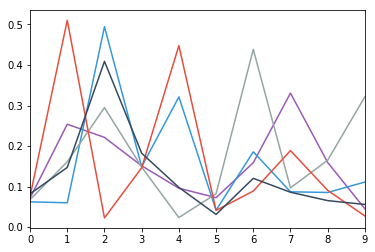

In [131]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["X_time_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

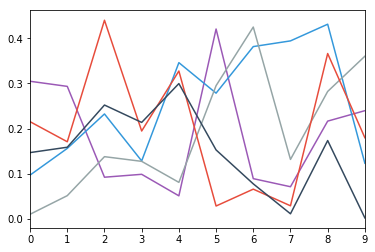

In [132]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[normal_test_example_index]["X_features_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

### Anomalous Example

In [133]:
anomalous_test_example_index = np.argmax(arr_test_labels == '1')

In [134]:
predictions_list[anomalous_test_example_index]

{'X_features_abs_reconstruction_error': array([[ 0.48738524,  0.12764417,  0.27545787,  0.02086223,  0.11666452],
        [ 1.04577356,  1.31647976,  1.74335495,  2.35347563,  1.59948202],
        [ 2.40304427,  0.36678881,  0.17685395,  3.60838123,  0.22505877],
        [ 2.81820559,  2.6182128 ,  0.88234383,  3.61548355,  2.07704568],
        [ 1.60923975,  0.43553352,  0.9918377 ,  1.72106437,  1.0877147 ],
        [ 4.96550164, 10.19599802,  0.07018991,  2.8962608 ,  2.60716468],
        [ 4.63395332,  2.00450139,  3.30348221,  5.22680759,  5.46134923],
        [ 5.60685954,  9.18115975,  8.715433  ,  5.1486596 , 10.11080805],
        [ 2.71213572,  1.95415   ,  5.35981581,  2.66384922,  8.20040237],
        [ 2.00153017,  2.37384245,  6.29866731,  2.52741371,  8.42312626]]),
 'X_time_abs_reconstruction_error': array([[4.90966021e-02, 1.20202729e-01, 2.10563543e-01, 1.07241067e-01,
         1.23980443e-02],
        [1.16869028e-02, 2.12273381e-01, 3.08940625e-01, 4.01602760e-02,
  

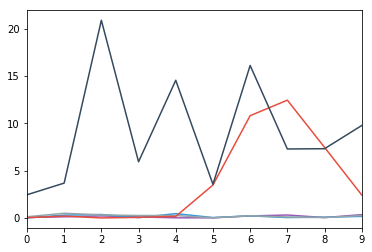

In [135]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["X_time_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )

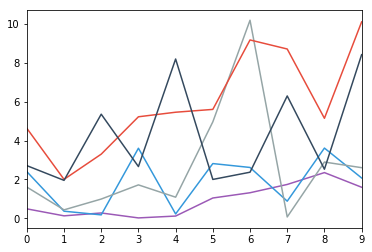

In [136]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
for i, arr in enumerate(np.split(ary = predictions_list[anomalous_test_example_index]["X_features_abs_reconstruction_error"].flatten(), indices_or_sections = len(UNLABELED_CSV_COLUMNS), axis = 0)):
    sns.tsplot(arr, color = flatui[i%len(flatui)] )